# Prediction of doctors prescribing dicisions


# Contents: <a class="anchor" id="contents"></a>

## [Introduction](#intro)

## 1. [Data](#import)

#### 1.1. [Library import, references and data loading](#import)
#### 1.2. [Preprocessing](#preprocessing)

## 2. [Fast analysis](#fanalysis)

## 3. [Feature engineering & deep analysis](#fe)

#### 3.2. [Feature engineering ](#fe)

#### 3.2. [Stat-analysis](#stat_a)

## 4. [The goal & feature selection](#goal-fs)


## 5. [Quality metrics](#quality-metrics)

## 7. [Basic Models](#basic_models)

#### 7.1. [ Logistic regression](#Log)
#### 7.2. [LinearSVC](#LinearSVC)
#### 7.3. [kNN (K-Nearest Neighbors)](#kNN)
#### 7.4. [DicisionTreeClassifier](#dtc)
#### 7.5. [Neural Network](#net)


## 8. [Ensemble and hybrid methods](#ensembles)

#### 8.1. [RandomForestClassifier](#rfc)
#### 8.2. [Bagging ](#stack)
#### 8.3 [Blending](#blending)
#### 8.4. [Stacking](#stack)

# Introduction <a class="anchor" id="intro"></a>
[back to contents](#contents)

    Medical facilities are dealing with a lot of patients and with the implementation of E-prescriptions, they can store and analyze their data easier. There is a lot of patients and doctors which means a lot of data. U.S. Centers for Medicare and Medicaid Services (CMS) released a dataset of 239,930 doctors from different regions, specialties, and their prescribing history. The dataset provides information on prescription drugs prescribed by individual physicians and other health care providers. And what do do with that data? With the help of machine learning, we can identify some patterns/connections between data that are hidden in the dataset. This was also the reason for releasing the CMS dataset to the public.

    There were a lot of articles written on a similar topic. As an example, we consider mining electronic health record data (EHR) with doctor’s medicine prescription. Here researchers use multi-task neural network approach to learn pattern of multiple correlated antidiabetic agents in blood glucose control and antihypertensive drugs in blood pressure control scenarios. The result demonstrated that for single drug prescription, multi-task learning achieves 0.02 to 0.06. increases in AUC compared with logistic regression. In prescription pattern prediction, they achieved an accuracy increase of 0.05 in antidiabetic agent prediction, showing the efficacy of multi-task learning approach in learning doctor prescription patterns.[13] Second example of data analyzing it’s prediction whether the patient will have a myocardial infarction. Researchers had to learn statistical model to indicate which patients on Cox-2 inhibitors, such as VioxxTM and CelebrexTM, are at substantial risk for heart attack. Here were tried many different types of algorithms, and chose the best four methods – Naïve Bayes, TAN(Transductive Adversarial Networks), Boosted Rules and SAYU-TAN (Score As You Use). They scored each candidate feature using area-under the ROC curve. All methods do good on this task. However, in table of average AUC-ROC SAYU dominates the proposition learners for false positive rates less than 0.75. Researchers found that using techniques from statistical relation model lead to improvements over both standard propositional learning techniques as well as relational learning techniques.[11] One more example investigation is prediction of medication non-adherence referring on French Health System’s reimbursement data. Here we consider different models of patient drug consumption in breast cancer treatments. Data is a sequence of events (hospitalizations and pharmacy transactions) with timestamps and a set of characteristics about the patient. Researchers compare the ability of four supervised learning algorithms -logistic regression, decision tree, gradient boosting, multilayer perceptron. Gradient boosting, compared to the two previous models, is harder to interpret. However, it focuses on weak learners and can offer a better prediction. AUCs are roughly 0.70 with Gradient Boosting having the best performances. A Cumulative Accuracy Profit curve (CAP or Lorenz curve) gives the second and third measures, indicating the ability of a model to accurately spot a patient at-risk. Gradient boosting and MLP have the best results but these "black box methods" are difficult to explain which might refrain their usages.[12]

    Based on the sidns from database with the help of machine learning techniques, I will determine which gender doctor belongs to. For implementation I used a programming language called Python. It offers a variety of different libraries which make machine learning and data analysis easier. I used a library called Pandas [6] for preprocessing, Seaborn [9] for plotting the graphs and Sklearn [10] for machine learning computation.

о библиотеках подробнее:

### [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)

* [базовые функции pandas](https://smysl.io/blog/pandas/)
* [справочник на русском по pandas](https://riptutorial.com/Download/pandas-ru.pdf)

### [matplotlib](https://matplotlib.org/3.1.1/users/index.html)

* [самоучитель](https://pyprog.pro/mpl/mpl_install.html)
* [отличная статья на английском](https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0)

# Lib import, references and data loading <a class="anchor" id="import"></a>
[back to contents](#contents)

### In this table of contents, our json file is read, and the various libraries are imported for further work with the database.

In [2]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics
from itertools import product
%matplotlib inline
from IPython.display import display, HTML, Image, Math

#### Read the file line by line, and save it to the `data` list

In [195]:
data = []
for line in open('roam_prescription_based_prediction.jsonl', 'r'):
    data.append(json.loads(line))     

#### Convert the dictionary using `json_normalize` to pandas.DataFrame

In [196]:
df = pd.io.json.json_normalize(data)
#df.head(2)

#### General table information:

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239930 entries, 0 to 239929
Columns: 2405 entries, cms_prescription_counts.1ST TIER UNIFINE PENTIPS to provider_variables.years_practicing
dtypes: float64(2397), int64(3), object(5)
memory usage: 4.3+ GB


In [4]:
ndf = df.copy()

# Preprocessing <a class="anchor" id="preprocessing"></a>
[back to contents](#contents)

### As our data file contains 4.3 Gb, we need to compress the table so that we can work further. For now, delete the `data` variable to unload the memory. Here we will also do some data pre-processing, which in the future will allow us to work with this data.

#### Fill the empty `NaN` values with zeros

In [197]:
df = df.fillna(0)

#### Set the row indexes of the table `npi` - the number of the doctor

In [198]:
df = df.set_index('npi')
#df.head(2)

#### Transform the table structure, move to the beginning the last 7 columns (`cols [: - 7]`) and reduce the headers with the `new_cols` variable.

In [199]:
cols = df.columns.tolist()
cols = cols[-7:] + cols[:-7]
df = df[cols]

#### Assign the header table to `new_cols` which, using the` for n in cols: `loop, and the regular expression` re.sub (...) `, reduce the headings to the original ones, removing the prefixes that formed after normalization.

In [200]:
new_cols = []
for n in cols:
    if n.count('provider_variables.') == 1:
        n = re.sub('provider_variables.', '', n)
    if n.count('cms_prescription_counts.') == 1:
        n = re.sub('cms_prescription_counts.', '', n)
    new_cols.append(n)

In [201]:
df.columns = new_cols
#df.head(2)

In [216]:
df.shape

(239930, 2404)

#### Optimize the data on prescribed medications so that the table takes up less space.

In [202]:
float_df_1 = df[new_cols[7:1200]]
converted_int_1 = float_df_1.apply(pd.to_numeric,downcast='signed')
del float_df_1

In [203]:
float_df_2 = df[new_cols[1200:]]
converted_int_2 = float_df_2.apply(pd.to_numeric,downcast='signed')
del float_df_2

#### Let's create the table `drugs` which will contain the database of prescribed recipes.

In [204]:
drugs = pd.concat([converted_int_1,converted_int_2],axis=1)

In [205]:
drugs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239930 entries, 1295763035 to 1144252818
Columns: 2397 entries, 1ST TIER UNIFINE PENTIPS to ZYVOX
dtypes: int16(863), int8(1534)
memory usage: 747.8+ MB


#### Create the table `main_df` in which the first part of the table will be located, without medical preparations.

In [206]:
main_df = df[new_cols[:7]]

#### Using the `.info ()` and `.describe ()` methods, we display general table information

In [207]:
print(main_df.info())
main_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 239930 entries, 1295763035 to 1144252818
Data columns (total 7 columns):
brand_name_rx_count    239930 non-null int64
gender                 239930 non-null object
generic_rx_count       239930 non-null int64
region                 239930 non-null object
settlement_type        239930 non-null object
specialty              239930 non-null object
years_practicing       239930 non-null int64
dtypes: int64(3), object(4)
memory usage: 14.6+ MB
None


,brand_name_rx_count,generic_rx_count,years_practicing
count,239930.000000,239930.000000,239930.000000
mean,176.264144,795.547047,6.241875
std,475.159281,1809.618284,1.649269
min,0.000000,0.000000,1.000000
25%,0.000000,36.000000,6.000000
50%,15.000000,145.000000,7.000000
75%,154.000000,750.000000,7.000000
max,30547.000000,101079.000000,8.000000


#### We have to convert categorical string data into `main_df` to numerical equivalents using the` get_dummies` method.
#### `gender`,` settlement_type` transform to the columns `male`,` urban`, where 1 is yes, 0 is no.
#### It is also possible to convert the `region` to 4 columns according to the number of unique values in the current column.

<a class="anchor" id="here2"></a>

In [208]:
male = pd.get_dummies(main_df['gender'])
urban = pd.get_dummies(main_df['settlement_type'])

# пока не уверен, что нужно его преобразовыавать
# region =  pd.get_dummies(main_df['region'])

#### Rename the column "M" to "male"

In [209]:
male = male.rename(columns={"M": "male"})

#### Combine 4 tables into one (pd.concat) and delete the extra columns (main_df.drop).

In [210]:
main_df = pd.concat([main_df, male, urban], axis = 1)

In [211]:
main_df= main_df.drop(['non-urban','F', 'gender','settlement_type'], axis=1)

In [212]:
main_df.sample(5)

,brand_name_rx_count,generic_rx_count,region,specialty,years_practicing,male,urban
npi,,,,,,,
1922196674,0,25,Midwest,General Practice,7,1,0
1851352942,347,1247,South,Neurology,7,1,0
1831112960,28,350,South,Sports Medicine,7,0,0
1457323313,0,26,Midwest,General Practice,7,1,0
1316028046,0,72,Midwest,General Practice,7,1,0


In [213]:
full_df = pd.concat([main_df, drugs], axis = 1)

In [215]:
full_df.shape

(239930, 2404)

In [218]:
full_df.to_csv('full_df.csv')

In [219]:
new_f_df = pd.read_csv('full_df.csv')

In [220]:
new_f_df.head(2)

,npi,brand_name_rx_count,generic_rx_count,region,specialty,years_practicing,male,urban,1ST TIER UNIFINE PENTIPS,ABACAVIR,...,ZYFLO,ZYFLO CR,ZYLET,ZYLOPRIM,ZYMAXID,ZYPREXA,ZYPREXA RELPREVV,ZYPREXA ZYDIS,ZYTIGA,ZYVOX
0,1295763035,384,2287,South,Nephrology,7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1992715205,0,103,South,General Practice,7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Fast analysis <a class="anchor" id="fanalysis"></a>
[back to contents](#contents)

### In this content of table we analyse data with using different statistical values and graphs. Graphical representation will help us to understand the interactions between attributes and discard the information that we don’t need.

#### Once again, the general information about the `.info ()` table is displayed, this time add the `all` argument to the` .describe (include = 'all') `function to find out the number of unique and most popular values for [data type `object`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html).

In [24]:
print(main_df.info())
main_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 239930 entries, 1295763035 to 1144252818
Data columns (total 7 columns):
brand_name_rx_count    239930 non-null int64
generic_rx_count       239930 non-null int64
region                 239930 non-null object
specialty              239930 non-null object
years_practicing       239930 non-null int64
male                   239930 non-null uint8
urban                  239930 non-null uint8
dtypes: int64(3), object(2), uint8(2)
memory usage: 11.4+ MB
None


,brand_name_rx_count,generic_rx_count,region,specialty,years_practicing,male,urban
count,239930.000000,239930.000000,239930,239930,239930.000000,239930.000000,239930.000000
unique,NaN,NaN,4,282,NaN,NaN,NaN
top,NaN,NaN,South,General Practice,NaN,NaN,NaN
freq,NaN,NaN,80562,47836,NaN,NaN,NaN
mean,176.264144,795.547047,NaN,NaN,6.241875,0.623753,0.365357
std,475.159281,1809.618284,NaN,NaN,1.649269,0.484444,0.481531
min,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.000000
25%,0.000000,36.000000,NaN,NaN,6.000000,0.000000,0.000000
50%,15.000000,145.000000,NaN,NaN,7.000000,1.000000,0.000000
75%,154.000000,750.000000,NaN,NaN,7.000000,1.000000,1.000000


#### We can see:

<font color=red> 
    
* mean value `brand_name_rx_count` and `generic_rx_count` 176 and 795 respectively;

* **quartile:**
* `25%` the smallest values of column `generic_rx_count` have median score 36;
* similarly, `75% of the values of the column` brand_name_rx_count` have a score of 175 or lower;
* `25%` of the `years_practicing` column values have a score of 6 or less, and mean of 6.24;

* 62% - male;
* 36% percent practice outside the city;

* there are 4 options for the `region` column
* there are 282 `specialty`, most often (47,836 times) occurs` General Practice`

</font><a class="anchor" id="1!"></a>

[почему важно понимать как распределены данные?](https://ru.coursera.org/lecture/znakomstvo-r-bazovaya-statistika/miediana-i-kvantili-Tj9Lf)

#### Let's look at the distribution of quantitative traits. The chart below shows the distribution of practicing years for doctors. From this distribution we can see that in our database most of doctors who practice from 6 to 8 years (most 7 years).

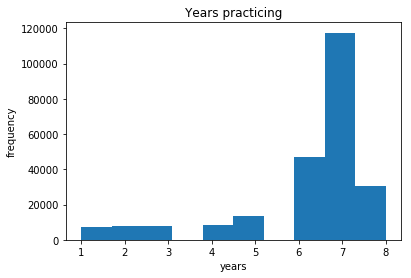

In [119]:
fig = plt.hist(main_df.years_practicing)
plt.title('Years practicing')
plt.xlabel("years")
plt.ylabel("frequency")

plt.savefig('years_practicing_hist.tiff', transparent=False, dpi=300, bbox_inches="tight")

#### Let's graphically show the percentage of doctors by gender. In this case, 1 is a male and 0 is a female. In our database, the number of male doctors exceeds the number of female doctors.

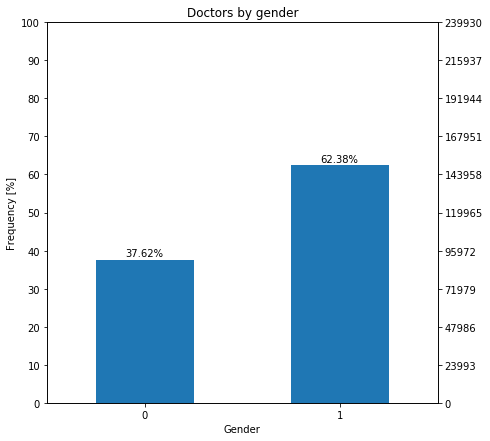

In [120]:
# Percent doctors by gender
plt.figure(figsize=(7,7))
plt.title('Doctors by gender')
plt.xlabel('Gender')
plt.ylabel('Frequency [%]')

ax = (main_df.male.value_counts()/len(main_df)*100).sort_index().plot(kind="bar", rot=0)
ax.set_yticks(np.arange(0, 110, 10))

ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(df)/100)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
plt.savefig('doctors_by_gender.tiff', transparent=False, dpi=300, bbox_inches="tight")

#### Next boxplot presents years practicing by gender and region. The boxplot extends from the lower to upper quartile values of the data, with a line at the median. The whiskers extend from the box to show the range of the data. Flier points are those past the end of the whiskers.
#### At the boxplot we can see that mean value of years practicing for each doctor usually is 6 years, most of female doctors from South and Midwest have 4 years practicing, while doctors from West and Northeast have 5 years. The quartile values are ranged from 1 to 8 - for first two regions, and rom 2 to 8 - for two other.

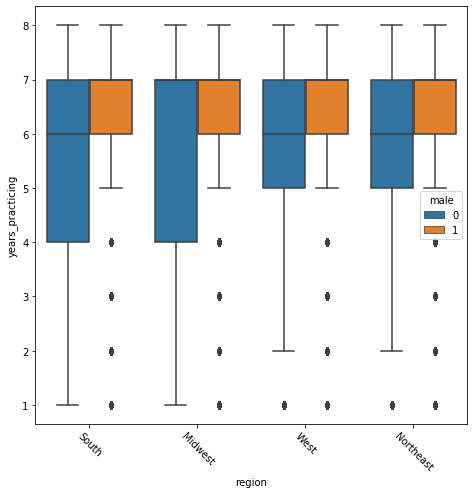

In [45]:
#Years practicing by region&gender
plt.figure(figsize=(15,10))
sns.boxplot(data=main_df,
            y='years_practicing',
            x='region',
            hue='male') 
plt.xticks(rotation=-45) 
plt.gcf().subplots_adjust(left=0.50, bottom = 0.30)
plt.savefig('years_practicing_by_region_gender.tiff', format='tiff', dpi=300)


<font color = red>в чем суть графика</font>
(https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)<a class="anchor" id="2!"></a>


<Figure size 720x1440 with 0 Axes>

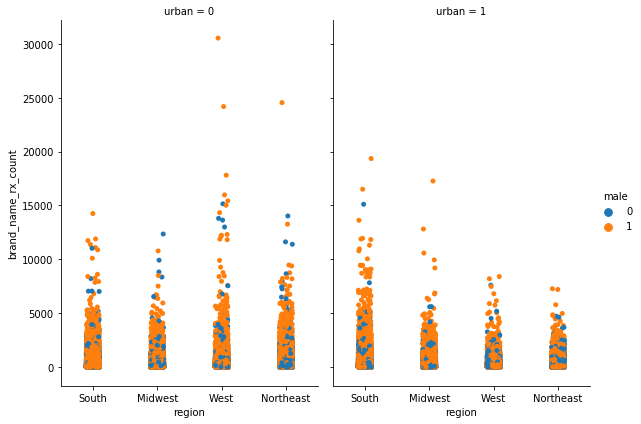

In [42]:
plt.figure(figsize=(10,20))
sns.catplot(x="region", y="brand_name_rx_count",
            hue="male", col="urban",
            data=main_df, kind="strip",
            height=6, aspect=.7)

plt.savefig('brand_name_rx_count_fast.tiff', format='tiff', transparent=False, dpi=300, bbox_inches="tight")

<Figure size 720x1440 with 0 Axes>

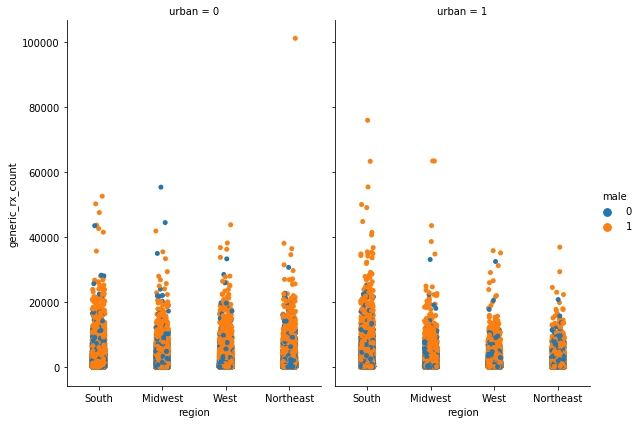

In [43]:
plt.figure(figsize=(10,20))
sns.catplot(x="region", y="generic_rx_count",
            hue="male", col="urban",
            data=main_df, kind="strip",
            height=6, aspect=.7)

plt.savefig('generic_rx_count_fast.tiff', format='tiff', transparent=False, dpi=300, bbox_inches="tight")

Выделяю ряд точек, которые сильно выбиваются от общей группы, в основнлм это показатели врачей-мужчин.

### Изучим распределение специальностей врачей в нашей таблице.

<a class="anchor" id="here"></a>

Трансформируем колонку `specialty` в числовые значения, для этого сначала копирем `main_df` в `pairplot_df`. После перевожу строковые значения в числовые:

In [46]:
pairplot_df = main_df.copy()

In [47]:
specialty_dict = dict(enumerate(pairplot_df['specialty'].astype('category').cat.categories))
pairplot_df['specialty']  = pairplot_df['specialty'].astype('category')
pairplot_df['specialty'] = pairplot_df['specialty'].cat.codes

номера специальностей сохраняю в словарь `specialty_dict`

In [48]:
specialty_dict

{0: 'Acute Care',
 1: 'Addiction (Substance Use Disorder)',
 2: 'Addiction Medicine',
 3: 'Addiction Psychiatry',
 4: 'Administrator',
 5: 'Adolescent Medicine',
 6: 'Adolescent and Children Mental Health',
 7: 'Adult Development & Aging',
 8: 'Adult Health',
 9: 'Adult Medicine',
 10: 'Adult Mental Health',
 11: 'Adult Reconstructive Orthopaedic Surgery',
 12: 'Aerospace Medicine',
 13: 'Allergy',
 14: 'Allergy & Immunology',
 15: 'Ambulatory Care',
 16: 'Ambulatory Surgical',
 17: 'Anatomic Pathology',
 18: 'Anatomic Pathology & Clinical Pathology',
 19: 'Assistive Technology Practitioner',
 20: 'Athletic Trainer',
 21: 'Behavioral Neurology & Neuropsychiatry',
 22: 'Blood Banking & Transfusion Medicine',
 23: 'Body Imaging',
 24: 'Cardiac Rehabilitation',
 25: 'Cardiovascular Disease',
 26: 'Cardiovascular Invasive Specialist',
 27: 'Cardiovascular-Interventional Technology',
 28: 'Case Management',
 29: 'Child & Adolescent Psychiatry',
 30: 'Child Abuse Pediatrics',
 31: 'Children'

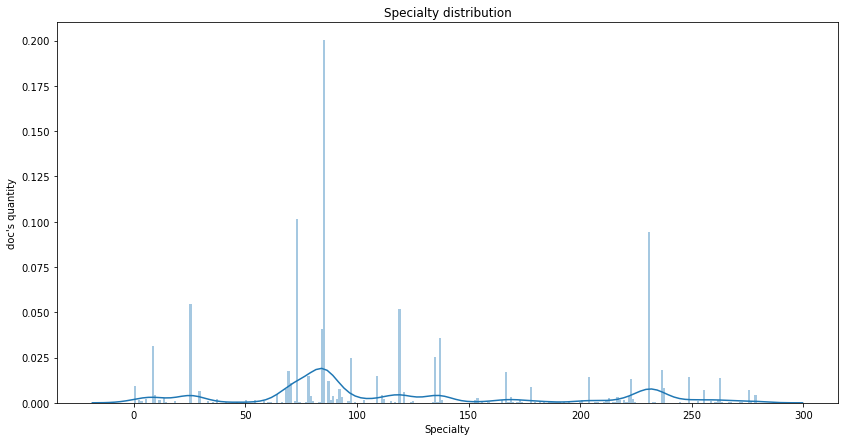

In [49]:
plt.figure(figsize=(14,7))
fig = sns.distplot(pairplot_df['specialty'], bins=282 )
plt.title('Specialty distribution')
plt.xlabel("Specialty")
plt.ylabel("doc's quantity")

plt.savefig('specialty_distribution.tiff', transparent=False, dpi=300, bbox_inches="tight")

### видим пики

(70, 90)

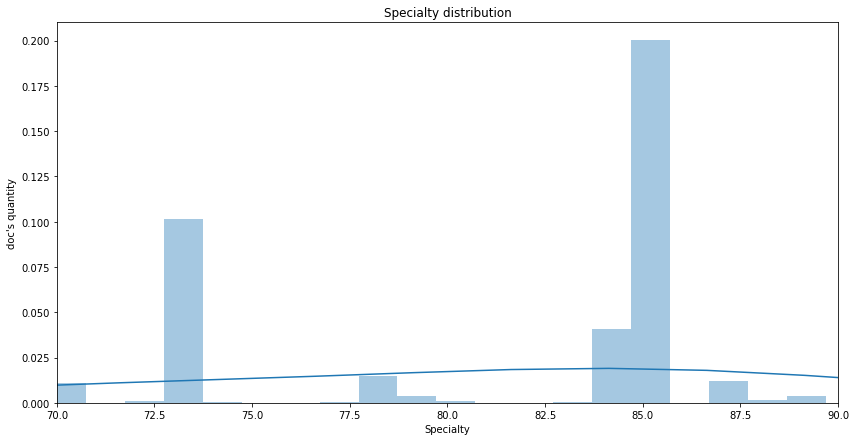

In [50]:
# если нужно увеличить и посмотреть номер специальности, пользуюсь xlim

plt.figure(figsize=(14,7))
fig = sns.distplot(pairplot_df['specialty'], bins=282)
plt.title('Specialty distribution')
plt.xlabel("Specialty")
plt.ylabel("doc's quantity")
# ------------------
plt.xlim(70,90)

Вижу, что специальности под номером 73 и 85 имеют наибольшее значение:

In [57]:
specialty_dict[73], specialty_dict[85]

('Family', 'General Practice', 'Gastroenterology')

In [62]:
# проверяем совпадение

main_df.specialty.value_counts()[:10]

General Practice          47836
Family                    24230
Psychiatry                22530
Cardiovascular Disease    13091
Medical                   12445
Gastroenterology           9695
Neurology                  8501
Adult Health               7444
Nephrology                 5997
Hematology & Oncology      5852
Name: specialty, dtype: int64

In [69]:
main_df.specialty.value_counts()[:5].values.sum()/len(main_df)

0.5006960363439337

#### таким образом у нас 5 специальностей, которые составляют 50% выборки

### Посмотрим существует ли корреляция между признаками:

#### Let's plot a pair correlation chart of 3 indicators using the `seaborn` library (imported as` sns`) and its `.pairplot ()` method. Arguments methods (given in brackets):
* `main_df` - our data;
* `vars` - columns that we want to visualize;
* `kind = reg` - add a red regression line to the chart to indicate a trend;
* `plot_kws` - a dictionary in which the visualization settings, colors and transparency of the points are indicated.

####  Here we do not see the real picture, but we understand that doctors prescribe up to 3 thousand brand drugs and 10 thousand generics.

In [242]:
pairplot_df.head(2)

,brand_name_rx_count,generic_rx_count,region,specialty,years_practicing,male,urban
npi,,,,,,,
1295763035,384,2287,South,135,7,1,0
1992715205,0,103,South,85,7,1,0


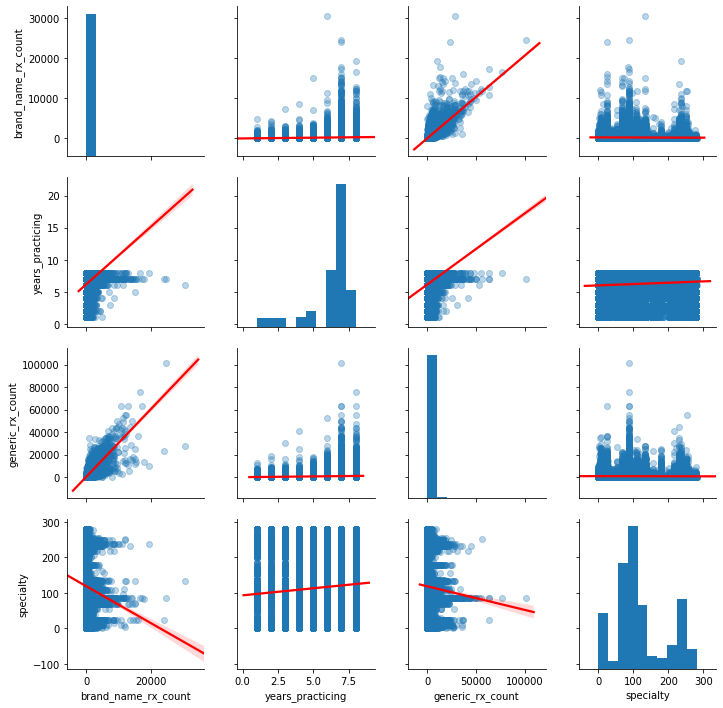

In [245]:
sns.pairplot(pairplot_df, vars=['brand_name_rx_count',
                                'years_practicing',
                                'generic_rx_count',
                                'specialty'],
             kind='reg',
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})

Есть устойчивый тренд корреляции лет практики и количества препаратов, и обратная корреляция количества препаратов с номером специальности.

No handles with labels found to put in legend.


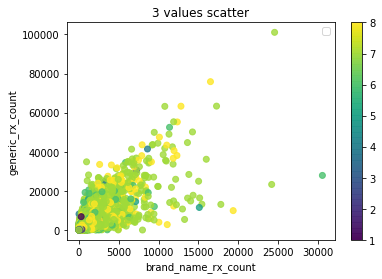

In [246]:
fig = plt.scatter(x=main_df.brand_name_rx_count, y=main_df.generic_rx_count, c=main_df.years_practicing, alpha=0.8)
plt.title('3 values scatter')
plt.xlabel("brand_name_rx_count")
plt.ylabel("generic_rx_count")
plt.colorbar(fig)
plt.savefig('3_values_scatter.tiff', transparent=False, dpi=300, bbox_inches="tight")

### После графиков необходимо отметиь что видим выборсы (данные которые сильно отличаются от остальных и могут влиять на обучение модели).

# Feature engineering <a class="anchor" id="fe"></a>
[back to contents](#contents)

#### I want to teach a model to predict the gender of a doctor. Now we will work with `main_df`, to add new attributes.

#### Create a new attribute (column) `bn_rx_proportion`, which will evaluate the relationship between the types of prescribed drugs. This proportion shows how many times `brand_name_rx_count` exceeds `generic_rx_count ` if the it is greater than another one. Or how many times it is less, if vice versa.

In [109]:
main_df['bn_rx_proportion'] = main_df['brand_name_rx_count'] / main_df['generic_rx_count']

#### As a result of dividing by `0`, the values of` inf` (infinity) were added, we replace these values with `0`. 

In [110]:
main_df = main_df.replace([np.inf, -np.inf], 0)

In [112]:
main_df.describe(include='all')

,brand_name_rx_count,generic_rx_count,region,specialty,years_practicing,male,urban,bn_rx_proportion
count,239930.000000,239930.000000,239930,239930,239930.000000,239930.000000,239930.000000,239930.000000
unique,NaN,NaN,4,282,NaN,NaN,NaN,NaN
top,NaN,NaN,South,General Practice,NaN,NaN,NaN,NaN
freq,NaN,NaN,80562,47836,NaN,NaN,NaN,NaN
mean,176.264144,795.547047,NaN,NaN,6.241875,0.623753,0.365357,0.218467
std,475.159281,1809.618284,NaN,NaN,1.649269,0.484444,0.481531,0.696692
min,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000
25%,0.000000,36.000000,NaN,NaN,6.000000,0.000000,0.000000,0.000000
50%,15.000000,145.000000,NaN,NaN,7.000000,1.000000,0.000000,0.065728
75%,154.000000,750.000000,NaN,NaN,7.000000,1.000000,1.000000,0.204597


#### Create a column to calculate the number of different drugs prescribed by doctors in the table `drugs`. To do this, use the construction with the unnamed function [`lambda`](https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7).

In [104]:
# создаю столбец   из общего кол-ва (2397)   вычитаю все столбцы с 0
drugs['drugs_variety'] = 2397 - drugs.apply(lambda x: x.isin([0]).sum(), axis='columns')

#### Combine `main_df` and` drugs` into a table similar to the original one, but with new features `bn_rx_proportion` and` drugs_variety`.

In [113]:
main_df = pd.concat([main_df, drugs.drugs_variety],axis=1)

In [114]:
main_df.head(2)

,brand_name_rx_count,generic_rx_count,region,specialty,years_practicing,male,urban,bn_rx_proportion,drugs_variety
npi,,,,,,,,,
1295763035,384,2287,South,Nephrology,7,1,0,0.167906,68
1992715205,0,103,South,General Practice,7,1,0,0.000000,3


#### It is also possible to convert the `region` to 4 columns according to the number of unique values in the current column.

# есть 2 варианта преобразования, мы воспользуемся обоими: создадим 2 очень похожие таблицы:

In [136]:
cat_df = main_df.copy()
region_dict = dict(enumerate(cat_df['region'].astype('category').cat.categories))
cat_df['region']  = cat_df['region'].astype('category')
cat_df['region'] = cat_df['region'].cat.codes
cat_df.head(2)

,brand_name_rx_count,generic_rx_count,region,specialty,years_practicing,male,urban,bn_rx_proportion,drugs_variety
npi,,,,,,,,,
1295763035,384,2287,2,Nephrology,7,1,0,0.167906,68
1992715205,0,103,2,General Practice,7,1,0,0.000000,3


In [117]:
regions = pd.get_dummies(main_df['region'])
W_df = pd.concat([main_df, regions], axis = 1)
W_df= W_df.drop('region', axis=1)
W_df.head(2)

,brand_name_rx_count,generic_rx_count,specialty,years_practicing,male,urban,bn_rx_proportion,drugs_variety,Midwest,Northeast,South,West
npi,,,,,,,,,,,,
1295763035,384,2287,Nephrology,7,1,0,0.167906,68,0,0,1,0
1992715205,0,103,General Practice,7,1,0,0.000000,3,0,0,1,0


### Выделим основные направления в специальностях врачей, попробуем создать новые признаки. Все операции выполняю с таблицей `W_df`:

In [119]:
W_df.specialty.value_counts().head(10)

General Practice          47836
Family                    24230
Psychiatry                22530
Cardiovascular Disease    13091
Medical                   12445
Gastroenterology           9695
Neurology                  8501
Adult Health               7444
Nephrology                 5997
Hematology & Oncology      5852
Name: specialty, dtype: int64

In [120]:
top_spec= list(W_df.specialty.value_counts().head(5).index)
top_spec

['General Practice',
 'Family',
 'Psychiatry',
 'Cardiovascular Disease',
 'Medical']

In [121]:
W_df[W_df.specialty.isin(top_spec)]['male'].value_counts()

1    71479
0    48653
Name: male, dtype: int64

In [122]:
71479 / len(W_df[W_df.specialty.isin(top_spec)])

0.5950038291212999

Видим, что соотношение мужчин и женщин среди **топ 5** специальностей, бизко к общей выборке. Но существует гипотеза, что от спецальности к специальности доля мужчин и женщин может отличаться.

In [73]:
W_df[W_df.specialty.str.contains('Endo', flags=re.IGNORECASE, regex=True)].specialty.value_counts()

Endocrinology, Diabetes & Metabolism      4136
Endodontics                               2664
Reproductive Endocrinology                 143
Pediatric Endocrinology                    133
Endoscopy                                    1
Reproductive Endocrinology/Infertility       1
Name: specialty, dtype: int64

In [123]:
W_df[W_df.specialty.str.contains('Geriat', flags=re.IGNORECASE, regex=True)].specialty.value_counts()

Geriatric Medicine      2889
Geriatric Psychiatry     339
Geriatric                 10
Name: specialty, dtype: int64

Добавим дополнительную классификацию специальностей, с помощью функцию `specialty_classify`, которая упростит ручную работу:

In [125]:
def specialty_classify(df, spec, my_class):
    df.loc[df['specialty'].str.contains(spec, flags=re.IGNORECASE, regex=True), str(my_class)] = 1

Функция добавляет новый столбец, который получает название `my_class`. `my_class` содержит `1` если значение в столбце `specialty` исходной таблицы, содержит строку `spec`.

пример:

отработав код `specialty_classify(main_df, 'Nephro', 'nephrology')` получим:

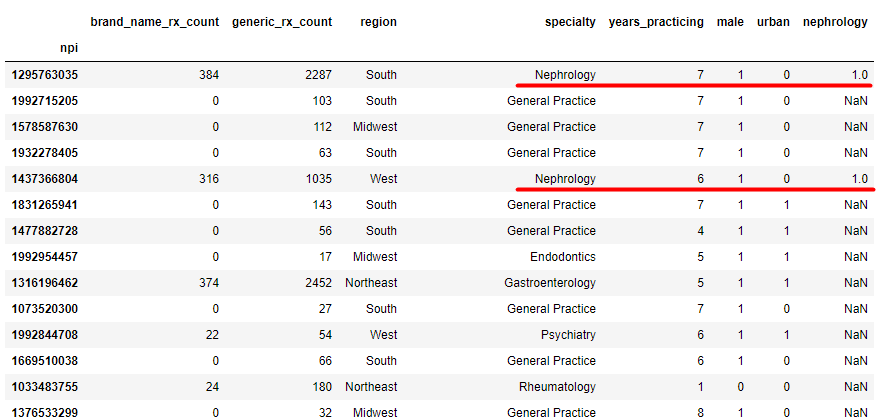

In [126]:
Image(filename='spec_classify_func.png')

Обобщенно выыделим наиболее востребованные специальности, и соберем их в словарь, чтобы позже отработать нашу функцию в цикле. Категоризирую представителей самых распространенных специальностей, чтобы добавить каждому врачу соответствующий признак.

как формируется словарь,на примере:

`'gynecol|female|women' : 'female_doctor'`

* слева от двоеточия, через знак `|` идет перечесление ключевых слов или частей слов - это ключи словаря,

* справа те значения которые соответствуют ключу словря - значения.

[документация](https://docs.python.org/3/library/stdtypes.html#dict)

In [127]:
# здесь вы можете сделать выборку более разумной

spec_dict = {'gynecol|female|women' : 'female_doctor',
             'Practice|Family':'practice',
             'Surg':'Surgery',
             'Endocr':'Endocrinology',
             'Urolog':'urology',
             'dent' : 'dentistry',
             'Pain' : 'paint_medicine',
             'Pediatr|Child' : 'pediatry',
             'Immuno': 'immunology',
             'Radio':'Radiology',
             'sport':'sport_medicine',
             'Gastroe':'Gastroenterology',
             'Infect':'Infectious',
             'Rheuma':'Rheumatology',
             'Cardio':'Cardiology',
             'Psyc':'Psychiatry',
             'Onco':'Oncology',
             'Nephro':'Nephrology',
             'Pulmon':'Pulmonology',
             'Geriat':'Geriatric',
             'Technol':'Technology'}

In [131]:
len(spec_dict)

21

In [128]:
for k,v in spec_dict.items():
    specialty_classify(W_df, k, v)

In [129]:
W_df.sample(5)

,brand_name_rx_count,generic_rx_count,specialty,years_practicing,male,urban,bn_rx_proportion,drugs_variety,Midwest,Northeast,...,Gastroenterology,Infectious,Rheumatology,Cardiology,Psychiatry,Oncology,Nephrology,Pulmonology,Geriatric,Technology
npi,,,,,,,,,,,,,,,,,,,,,
1215151444,0,71,Prosthodontics,6,0,0,0.000000,3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1316044878,362,1471,Nephrology,7,1,1,0.246091,34,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1063535938,45,29,General Practice,6,1,0,1.551724,4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1730270588,0,13,General Practice,7,1,0,0.000000,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1194774034,286,1785,Pain Medicine,7,1,0,0.160224,34,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
W_df[W_df.columns[-21:]] = W_df[W_df.columns[-21:]].apply(pd.to_numeric,downcast='signed')
# W_df = W_df.fillna(0)
W_df.head()

,brand_name_rx_count,generic_rx_count,specialty,years_practicing,male,urban,bn_rx_proportion,drugs_variety,Midwest,Northeast,...,Gastroenterology,Infectious,Rheumatology,Cardiology,Psychiatry,Oncology,Nephrology,Pulmonology,Geriatric,Technology
npi,,,,,,,,,,,,,,,,,,,,,
1295763035,384,2287,Nephrology,7,1,0,0.167906,68,0,0,...,0,0,0,0,0,0,1,0,0,0
1992715205,0,103,General Practice,7,1,0,0.000000,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1578587630,0,112,General Practice,7,1,0,0.000000,3,1,0,...,0,0,0,0,0,0,0,0,0,0
1932278405,0,63,General Practice,7,1,0,0.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1437366804,316,1035,Nephrology,6,1,0,0.305314,53,0,0,...,0,0,0,0,0,0,1,0,0,0


In [134]:
#  .T - разворачивает таблицу относительно основной диагонали, так удобнее читать данные:
W_df.describe().T

,count,mean,std,min,25%,50%,75%,max
brand_name_rx_count,239930.0,176.264144,475.159281,0.0,0.0,15.000000,154.000000,30547.000000
generic_rx_count,239930.0,795.547047,1809.618284,0.0,36.0,145.000000,750.000000,101079.000000
years_practicing,239930.0,6.241875,1.649269,1.0,6.0,7.000000,7.000000,8.000000
male,239930.0,0.623753,0.484444,0.0,0.0,1.000000,1.000000,1.000000
urban,239930.0,0.365357,0.481531,0.0,0.0,0.000000,1.000000,1.000000
bn_rx_proportion,239930.0,0.218467,0.696692,0.0,0.0,0.065728,0.204597,170.068966
drugs_variety,239930.0,20.121202,29.794904,1.0,2.0,7.000000,27.000000,490.000000
Midwest,239930.0,0.208715,0.406391,0.0,0.0,0.000000,0.000000,1.000000
Northeast,239930.0,0.245955,0.430653,0.0,0.0,0.000000,0.000000,1.000000
South,239930.0,0.335773,0.472261,0.0,0.0,0.000000,1.000000,1.000000


видим, что к категории `practice` - относится 30% выборки, `Psychiatry` - 11%, обратите внимание, что один врач может иметь значение `1 (да)` в нескольких категория.

## <font color='green'>Перемещаем название специальности вначало, а переменную, которую хотим предсказывать в конец таблицы.</font>

In [137]:
cat_df = cat_df[ ['specialty'] + [ col for col in cat_df.columns if col != 'specialty' ] ]
cat_df = cat_df[ [ col for col in cat_df.columns if col != 'male' ]  + ['male'] ]
cat_df.head(2)

,specialty,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety,male
npi,,,,,,,,,
1295763035,Nephrology,384,2287,2,7,0,0.167906,68,1
1992715205,General Practice,0,103,2,7,0,0.000000,3,1


In [139]:
W_df = W_df[ ['specialty'] + [ col for col in W_df.columns if col != 'specialty' ] ]
W_df = W_df[ [ col for col in W_df.columns if col != 'male' ]  + ['male'] ]
W_df.head(2)

,specialty,brand_name_rx_count,generic_rx_count,years_practicing,urban,bn_rx_proportion,drugs_variety,Midwest,Northeast,South,...,Infectious,Rheumatology,Cardiology,Psychiatry,Oncology,Nephrology,Pulmonology,Geriatric,Technology,male
npi,,,,,,,,,,,,,,,,,,,,,
1295763035,Nephrology,384,2287,7,0,0.167906,68,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1992715205,General Practice,0,103,7,0,0.000000,3,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## <font color='green'>Создаю таблицы для каждого пола. Делаем это на основе `cat_df`, тк в этой таблице признак `region` имеет нужный нам формат.</font>

In [140]:
m_df = cat_df[cat_df['male'] == 1]
f_df = cat_df[cat_df['male'] == 0]

# Для всей таблицы

### Для brand_name (ось y) и:
- brand_name -> здесь просто указано, какое количество этих препаратов в файле (выше было выведено что их 239930 штук) 
- generic -> видна линейная корреляция, то есть при выписывании препаратов generic также наблюдается увеличение выписывания препаратов brand. 
- region -> cудя по графику, выписывание препаратов не сильно отличается по регионам, но есть выбросы. 
- years_practicing -> больше всего выписанных brand препаратов от 7 до 8 лет практики.
- urban -> судя по выведенному выше графику, примерно одинаково данные распределены
- bn_rx_proportion -> при увеличении brand_name увеличивается brand_proportion
- drugs_variety -> у drugs_variety и brand_name также линейная корреляция

### Для generic_rx_count (ось y) и:
- brand_name -> линейная корреляция
- region -> тоже самое, график неравномерный, есть выбросы, думаю не стоит рассматривать этот параметр вообще.
- years_practcing -> то же самое, можно смотреть от 7-8 лет
- urban -> можно не брать, также есть выбросы за пределы.
- bn_proportion -> здесь зависимость, что если пропорция увеличивается, значит generic уменьшается
- drugs_variety -> линейная зависимость есть

### Для drugs_variety (ось y) и:
- brand_name - линейная зависимость
- generic - линейная зависимость

<font color=red> Необходимо описать где заметны аномалии в данных. Как отличаются зависимости признаков в данных по мужчинам и женщианм. Численно вывести корреляцию можно методом `corr()`.</font><a class="anchor" id="3!"></a>

In [142]:
m_df.corr()

,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety,male
brand_name_rx_count,1.000000,0.799449,0.005221,0.134971,0.020605,0.198868,0.774740,NaN
generic_rx_count,0.799449,1.000000,0.000454,0.136284,0.037992,0.013104,0.868964,NaN
region,0.005221,0.000454,1.000000,-0.039388,0.025432,-0.001214,0.007915,NaN
years_practicing,0.134971,0.136284,-0.039388,1.000000,0.009784,0.076990,0.168337,NaN
urban,0.020605,0.037992,0.025432,0.009784,1.000000,-0.004104,0.023802,NaN
bn_rx_proportion,0.198868,0.013104,-0.001214,0.076990,-0.004104,1.000000,0.080796,NaN
drugs_variety,0.774740,0.868964,0.007915,0.168337,0.023802,0.080796,1.000000,NaN
male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color=red> Зависимость переменных друг от друга может иметь разную природу и нам важно понимать эти взаимосвязи. Пример:  мы искуственно создали новый признак `bn_rx_proportion`, который по сути отражает взаимосвязь между `brand_name_rx_count` и `generic_rx_count`. `brand_name_rx_count` и `generic_rx_count` сильно коррелируют, мы понимаем почему. Нужно ли нам оставить все 3 признака, или мы можем избавиться от каких-то?</font>

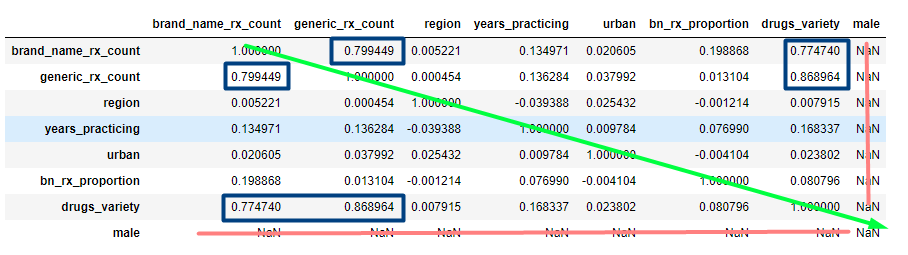

In [146]:
Image(filename='correletion.png')

In [143]:
f_df.corr()

,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety,male
brand_name_rx_count,1.000000,0.759766,-0.003404,0.123268,0.015109,0.171048,0.713361,NaN
generic_rx_count,0.759766,1.000000,0.003979,0.108495,0.035174,-0.016233,0.880358,NaN
region,-0.003404,0.003979,1.000000,0.008547,0.020110,-0.000639,0.007451,NaN
years_practicing,0.123268,0.108495,0.008547,1.000000,-0.023152,0.054022,0.100885,NaN
urban,0.015109,0.035174,0.020110,-0.023152,1.000000,-0.004802,0.043751,NaN
bn_rx_proportion,0.171048,-0.016233,-0.000639,0.054022,-0.004802,1.000000,0.016833,NaN
drugs_variety,0.713361,0.880358,0.007451,0.100885,0.043751,0.016833,1.000000,NaN
male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
m_ax = sns.pairplot(m_df.iloc[:, 1:-1], kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})

# сохранить
m_ax.savefig('m_df_corr.png', transparent=False, dpi=300, bbox_inches="tight")

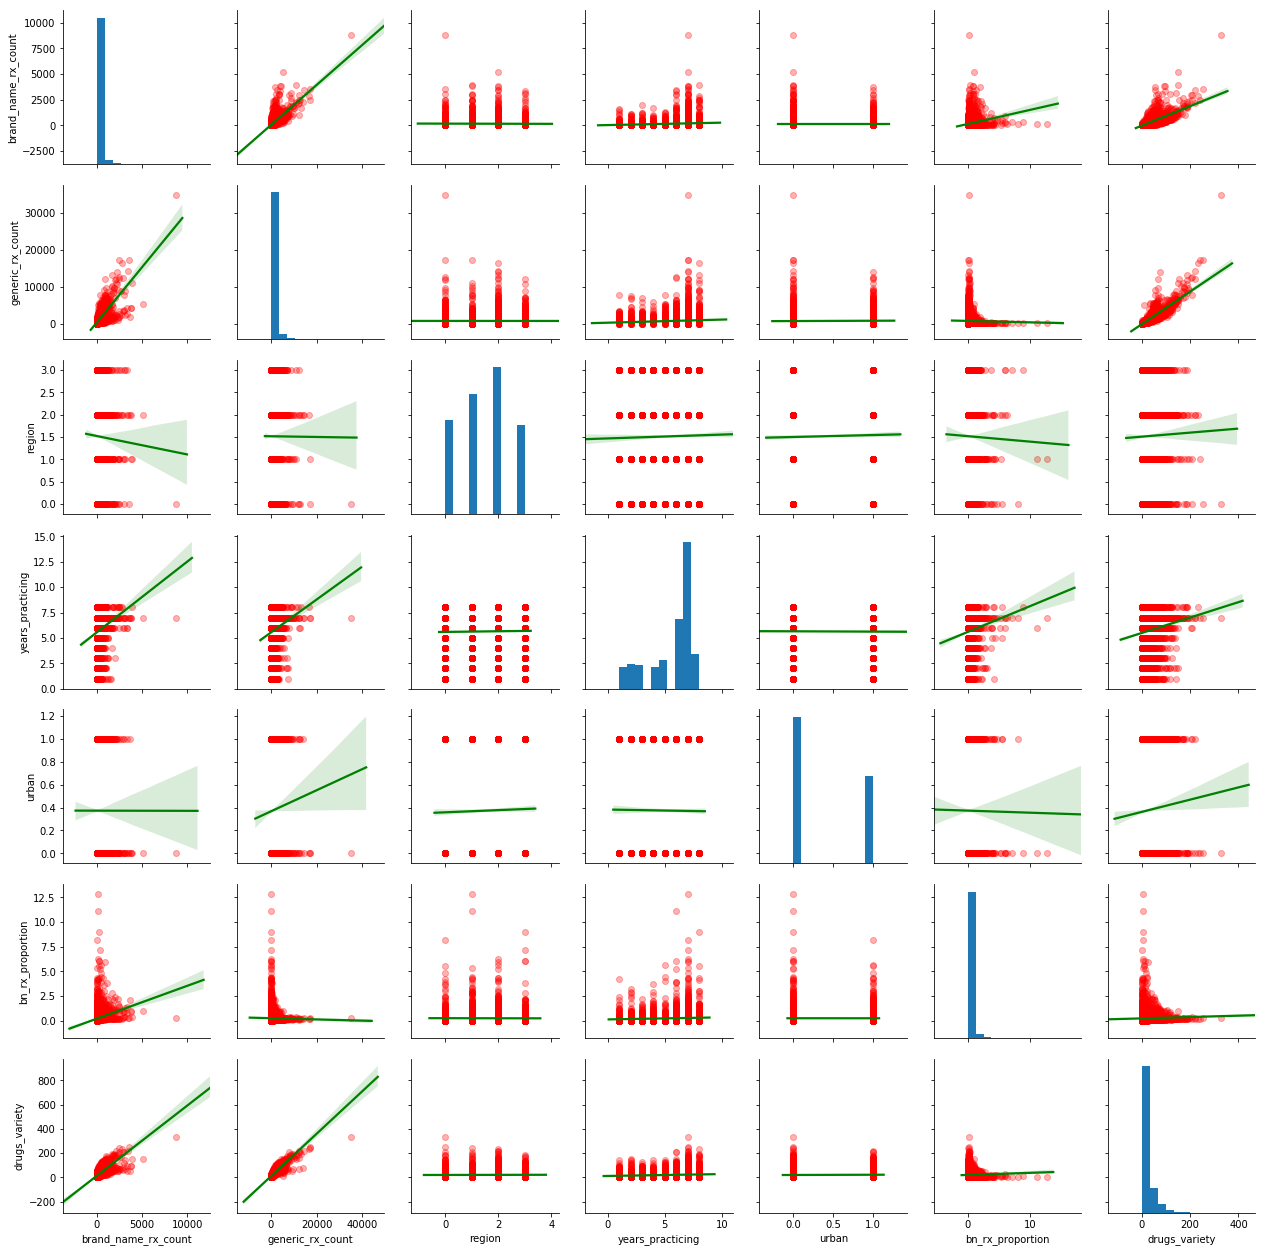

In [136]:
f_ax = sns.pairplot(f_df.iloc[:, 1:-1], kind='reg',
    plot_kws={'line_kws':{'color':'green'},
    'scatter_kws': {'color':'red', 'alpha': 0.3}})

f_ax.savefig('f_df_corr.png', transparent=False, dpi=400, bbox_inches="tight")

#### Scatter plot for 3 variables (bn_rx_proportion, brand_name_rx_count, years practicing) shows a lot amount of  proportions for  less than 5000 brand drugs for 7 years practicing.
### <font color=red> Ввод непонятен</font>

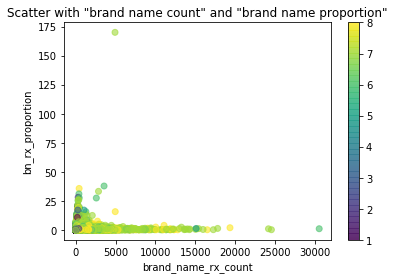

In [147]:
fig = plt.scatter(x=main_df.brand_name_rx_count,
                  y=main_df.bn_rx_proportion,
                  c=main_df.years_practicing,
                  alpha=0.6)
plt.title('Scatter with "brand name count" and "brand name proportion"')
plt.xlabel("brand_name_rx_count")
plt.ylabel("bn_rx_proportion")
plt.colorbar(fig)

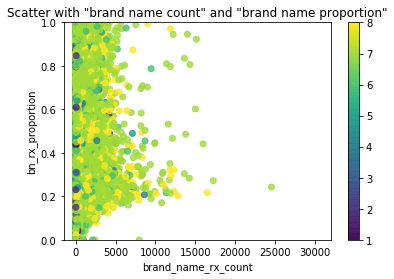

In [137]:
fig = plt.scatter(x=main_df.brand_name_rx_count,
                  y=main_df.bn_rx_proportion,
                  c=main_df.years_practicing,
                  alpha=0.6)
plt.title('Scatter with "brand name count" and "brand name proportion"')
plt.xlabel("brand_name_rx_count")
plt.ylabel("bn_rx_proportion")

# чтобы сделать график информативным мы смотрим только на значения bn_rx_proportion между 0 и 1
# с помощью ylim
plt.ylim(0, 1)
# ------------------

plt.colorbar(fig)
plt.savefig('Scatter_with_brand_name_count_and_proportion.png', transparent=False, dpi=300, bbox_inches="tight")

# <font color=red> Далее неинформативный блок? Стоит ли проводить оценку детализации по лекарствам? Необходимо объяснить решение не использовать детализированные данные по выписанным препаратам. Почему нам это не интересно?</font> 

#### We will collect a list of doctors and sort them by the number of representatives.

In [148]:
count_docs_spec = main_df.specialty.value_counts()
count_docs_spec[:10]

General Practice          47836
Family                    24230
Psychiatry                22530
Cardiovascular Disease    13091
Medical                   12445
Gastroenterology           9695
Neurology                  8501
Adult Health               7444
Nephrology                 5997
Hematology & Oncology      5852
Name: specialty, dtype: int64

#### Create a table to analyze the frequency of prescribing medications for certain specialties. Combine `main_df.specialty` and` drugs`.

In [274]:
drugs_count = pd.concat([main_df.specialty, drugs],axis=1)

In [275]:
drugs_count= drugs_count.drop('drugs_variety',axis=1)

#### We will also need `pandas` library methods: [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) [`T(transpose)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html).

In [277]:
drugs_count = drugs_count.groupby(['specialty']).sum()
drugs_count = drugs_count.T
drugs_count

specialty,Acute Care,Addiction (Substance Use Disorder),Addiction Medicine,Addiction Psychiatry,Administrator,Adolescent Medicine,Adolescent and Children Mental Health,Adult Development & Aging,Adult Health,Adult Medicine,...,Vascular & Interventional Radiology,Vascular Neurology,Vascular Sonography,Vascular Specialist,Vascular Surgery,Vision Therapy,Women,Women's Health,"Women's Health Care, Ambulatory",Wound Care
1ST TIER UNIFINE PENTIPS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABACAVIR,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,998.0,243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABELCET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABILIFY,567.0,45.0,3854.0,4714.0,0.0,1248.0,64.0,0.0,8876.0,3745.0,...,0.0,38.0,0.0,0.0,0.0,0.0,0.0,418.0,0.0,0.0
ABILIFY DISCMELT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABILIFY MAINTENA,0.0,0.0,34.0,64.0,0.0,0.0,0.0,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABRAXANE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABSTRAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACAMPROSATE CALCIUM,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACANYA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <font color=red> Ниже справочный блок, от него можно избавиться, если вы увернно ориентируетесь в данных.</font> 

## Дальше идут различные методы сортировки:

In [145]:
def to_10_prescription_by_spec(spec):
    print(drugs_count[spec].sort_values(ascending=False)[:10])

In [146]:
to_10_prescription_by_spec('Pulmonary Disease')

SPIRIVA                   606638.0
ADVAIR DISKUS             515898.0
PREDNISONE                368163.0
PROAIR HFA                339680.0
MONTELUKAST SODIUM        313831.0
SYMBICORT                 261288.0
AZITHROMYCIN              158565.0
OMEPRAZOLE                145859.0
FLUTICASONE PROPIONATE    142503.0
FUROSEMIDE                136863.0
Name: Pulmonary Disease, dtype: float64


#### Посмотрим какие врачи выписывают препараты чаще всего. Соберем таблицы в которые поместим врачей выписывающих большее количество рецептов. Используем сортировку по 2-м признакам (типам препаратов).

In [147]:
top_docs_bn_prescription = main_df.sort_values(by = ['brand_name_rx_count','generic_rx_count'], ascending=False)
top_docs_bn_prescription.head(20)

,specialty,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety,male
npi,,,,,,,,,
1720134695,Nephrology,30547,27912,3,6,0,1.094404,384,1
1598788689,Geriatric Medicine,24550,101079,1,7,0,0.242879,490,1
1043244296,Cardiovascular Disease,24184,23299,3,7,0,1.037984,223,1
1376541961,Pulmonary Disease,19355,9915,2,8,1,1.952093,59,1
1023124054,Gastroenterology,17806,13100,3,7,0,1.359237,219,1
1982654638,Geriatric Medicine,17267,63352,0,7,1,0.272557,406,1
1083619670,Geriatric Medicine,16505,75858,2,8,1,0.217578,421,1
1265488845,Cardiovascular Disease,15979,36182,3,7,0,0.441628,285,1
1356360887,Cardiovascular Disease,15428,13190,3,7,0,1.169674,230,1


#### Так же изучим врачей с нименьшим и наибольшим показателем `bn_rx_proportion`.

In [148]:
main_df[main_df['generic_rx_count'] != 0].sort_values(by='bn_rx_proportion', ascending=False).head(10)

,specialty,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety,male
npi,,,,,,,,,
1366493322,Preventive Medicine/Occupational Environmental...,4932,29,2,7,0,170.068966,13,0
1295875615,Otolaryngology/Facial Plastic Surgery,3558,94,0,6,1,37.851064,8,1
1174525927,Pulmonary Disease,429,12,1,8,1,35.750000,9,1
1053385815,Emergency Medical Services,2860,86,0,7,0,33.255814,7,1
1235264953,Adult Health,404,13,3,6,0,31.076923,9,1
1518250828,Infectious Disease,309,11,2,2,0,28.090909,9,1
1245425370,Pulmonary Disease,443,16,0,6,1,27.687500,9,0
1700936200,"Endocrinology, Diabetes & Metabolism",2585,94,2,6,1,27.500000,47,1
1356429088,Critical Care Medicine,390,15,3,7,1,26.000000,7,1


In [149]:
main_df[((main_df['years_practicing'] == 8)\
         & (main_df['brand_name_rx_count'] == 200))].sort_values(by='specialty',\
                                                ascending=False).head(10)

,specialty,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety,male
npi,,,,,,,,,
1871590737,Rheumatology,200,733,1,8,0,0.272851,20,0
1811990666,Rheumatology,200,1716,3,8,0,0.116550,35,0
1144204850,Pulmonary Disease,200,740,3,8,1,0.270270,33,1
1184614018,Pulmonary Disease,200,273,2,8,1,0.732601,19,1
1760479224,Psychiatry,200,1686,2,8,1,0.118624,52,1
1376535252,Psychiatry,200,1700,1,8,0,0.117647,36,0
1831173970,Psychiatry,200,1076,3,8,1,0.185874,38,1
1023002870,Psychiatry,200,996,2,8,1,0.200803,35,1
1821084641,Orthopaedic Surgery of the Spine,200,1225,3,8,0,0.163265,18,1


# Stat-analysis <a class="anchor" id="stat_a"></a>
[back to contents](#contents)


#### * позволяет оценить взаимосвязи между переменными, насколько группы данных однородные.

#### * чтобы узнать различаются ли группы между собой необходимо вычислить [t-критерий Стьюдента (подробнее о критерии и основах распределения)](https://github.com/sqrt495/easy_lections/blob/master/Distribution_types/Distribution_types_Part1.ipynb);

#### * используем библотеку `scipy` метод [`ttest_ind`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)`.

In [17]:
from scipy.stats import ttest_ind

# Проверка статистических гипотез

**Критерии значимости** являются показателем того, что лекарство(нпаример) действительно работает или что показатели случайны.


### Пример 1. Автобус со спящими пассажирами


В городе проходят 2 конференции: математиков и баскетболистов. Едет автобус со спящими пассажирами, которых нельзя будить, но известен их рост. Как понять, является ли пассажир футболистом или математиком?


Средний рост баскетболиста: 185-195 см


Средний рост человека: по данным всемирного сообщества учёных-медиков «NCD Risk Factor Collaboration» (NCD-RisC), средний рост российских женщин на 2014 год — 165,3 см, мужчин — 176,5 см


**Решение**: расстояние до среднего роста двух выборок (баскетболистов и математиков) с большой степенью вероятности будет свидетельствовать о том, к какой выборке относится тот или иной пассажир. Следовательно, две выборки имеют статистическое различие в росте.
<a class="anchor" id="5!"></a>

# Алгоритм проверки статистических гипотез

*   формулируется **основная гипотеза H0** и **альтернативная гипотеза H1**;
*   выбирается статистический критерий, с помощью которого будет проверяться гипотеза;
*   задаётся значение уровня значимости α;
*   находятся границы области принятия гипотезы;
*   делается вывод о принятии или отвержении основной гипотезы H0.

# [P-value или статистическая значимость](https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f)


P-значение, или значение вероятности, это статистическая величина, выраженная числом от 0 до 1, которая используется для проверки гипотезы. В клинических испытаниях данная величина применяется для определения, является ли полученный в клинических испытаниях результат случайным.

До начала сбора данных необходимо определить уровень значимости, который обычно равен 5 % (или 0,05), хотя в зависимости от исследования может быть выбран и другой показатель.

**Статистически значимым** (и позволяющим отвергнуть нулевую гипотезу)при этом считается результат, р-значение которого равно уровню значимости или меньше его. Это, как правило, обозначается следующим образом: p ≤ 0,05.

 При **небольшом p-значении** маловероятна случайность результатов, что дает основание **отвергнуть нулевую гипотезу**. При **большом p-значении** наблюдаемая разница может быть результатом случайности, и **предположение о нулевой гипотезе не может быть отвергнуто**.

In [35]:
main_df = pd.read_csv('out.scv') 
main_df = main_df.set_index('npi') 
main_df.head(2)

,specialty,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety,male
npi,,,,,,,,,
1295763035,Nephrology,384,2287,2,7,0,0.167906,68,1
1992715205,General Practice,0,103,2,7,0,0.000000,3,1


### Вспомним, как распредлены наши данные и какие виды распредления бывают впринципе.

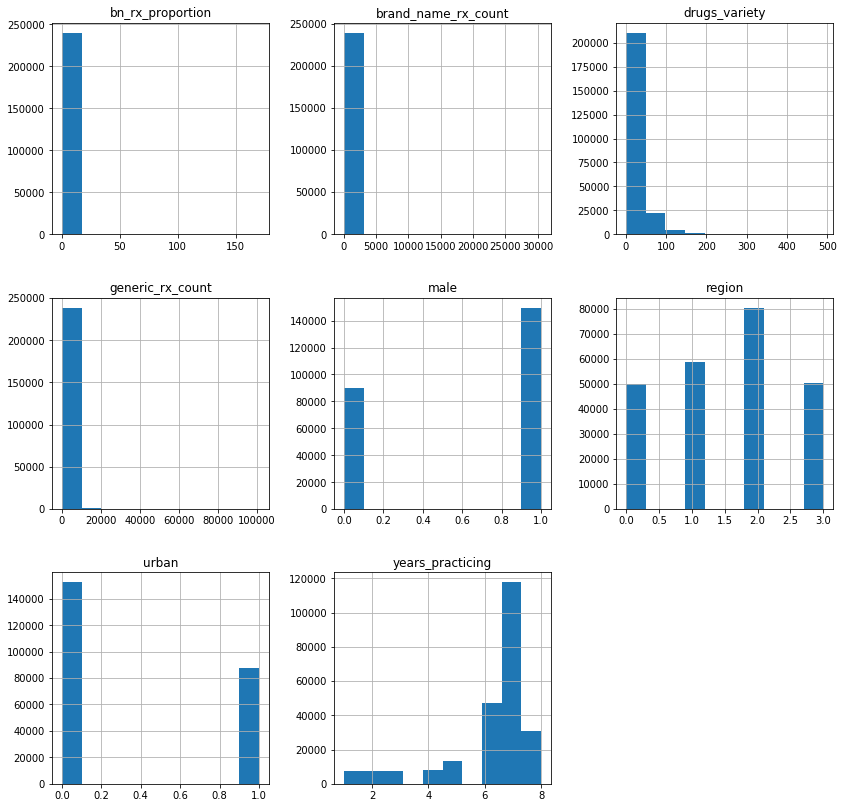

In [24]:
main_df.iloc[:,1:].hist(figsize=(14, 14));

In [25]:
HTML('<img src="https://habrastorage.org/getpro/habr/post_images/4f6/5f4/edb/4f65f4edb921715dbb56a320a65b101e.png">')

#### Удали экстиримальные отклонения в показателях `brand_name_rx_count` и `generic_rx_count` и посмотрим на рапределение еще раз.

In [44]:
cut_main_df = main_df[((main_df['brand_name_rx_count'] > 0)
                       & (main_df['brand_name_rx_count'] < 5500)
                       & (main_df['generic_rx_count'] > 0)
                       & (main_df['generic_rx_count'] < 20000))]

len(cut_main_df), len(main_df)

(130662, 239930)

Любопытно, что почти половина врачей в выборке не выписывает брендированные препараты.

In [46]:
len(main_df[main_df['brand_name_rx_count'] == 0])

104818

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215AD8DDF98>,
      dtype=object)

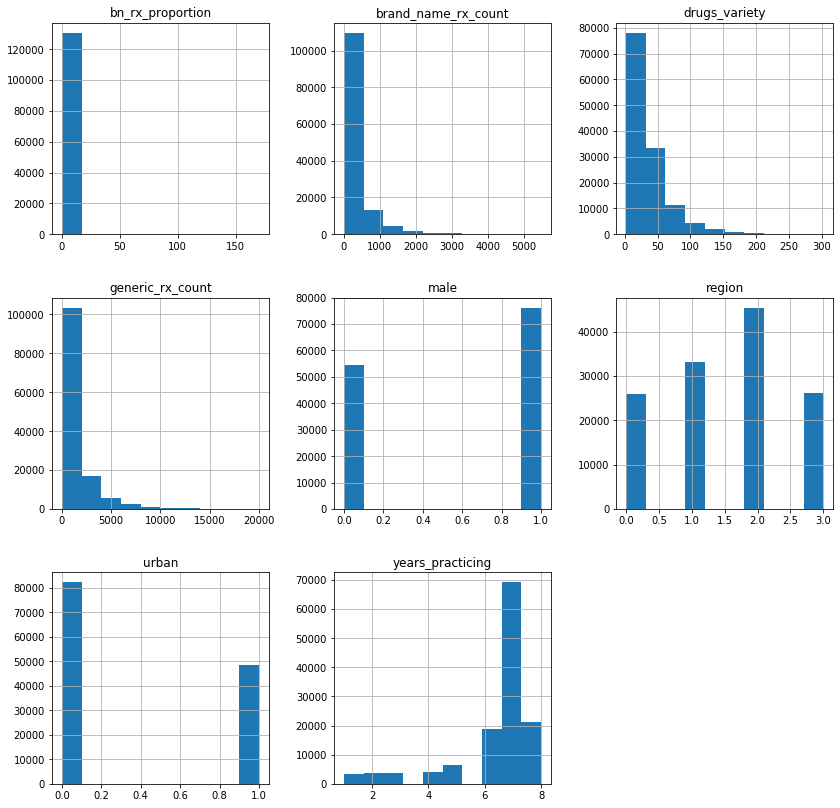

In [45]:
cut_main_df.iloc[:,1:].hist(figsize=(14, 14))

### Предположим, что вариативность рецептов у врачей мужчин и женщин не отличается, сделаем выборку по следующим условиям:

* `brand_name_rx_count > 20`
* `generic_rx_count < 20000`
* `years_practicing > 4`

Кол-во наблюдений:  36535 
Дисперсия:  1073.2396334711495


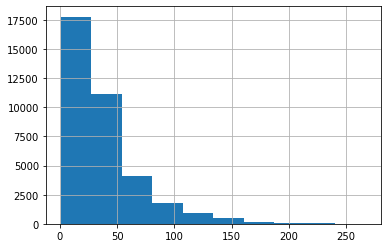

In [67]:
f_drugs_variety = main_df[((main_df['years_practicing'] > 4)
                                & (main_df['brand_name_rx_count'] > 20)
                                & (main_df['generic_rx_count'] < 20000)
                                & (main_df['male'] == 0))]['drugs_variety']
                           
print('Кол-во наблюдений: ',len(f_drugs_variety), '\nДисперсия: ', statistics.variance(f_drugs_variety))
f_drugs_variety.hist()

Кол-во наблюдений:  65043 
Дисперсия:  1180.525951356423


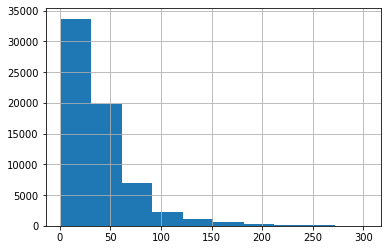

In [68]:
m_drugs_variety = main_df[((main_df['years_practicing'] > 4)
                                & (main_df['brand_name_rx_count'] > 20)
                                & (main_df['generic_rx_count'] < 20000)
                                & (main_df['male'] == 1))]['drugs_variety']
                           

print('Кол-во наблюдений: ',len(m_drugs_variety), '\nДисперсия: ', statistics.variance(m_drugs_variety))
m_drugs_variety.hist()

In [69]:
# уравняем выборки
m_drugs_variety = m_drugs_variety.sample(36535)

Воспользуемся критерием Манна-Уитни(`stats.mannwhitneyu`), чтобы подтвердить или опровергнуть нулевую гипотезу.

In [70]:
u, p_value = stats.mannwhitneyu(f_drugs_variety, m_drugs_variety)
print('Two-sample Mannwhitneyu-test = %.6f' % (p_value))

Two-sample Mannwhitneyu-test = 0.000000


#### Гипотеза, что вариативность выписки лекарст среди врачей-мужчинами и врачей-женщин схожа отвергается. Соответственно мы полагаем, что этот признак остается значимым для обучения моделей.

# The goal & Feature selection <a class="anchor" id="goal-fs"></a>
[back to contents](#contents)

Предсказываем `male` - последний признак исходных массивов. 

In [162]:
target_names=['female', 'male']

### У нас есть 2 таблицы с данными, еще раз вспоминаем в чем различия в `cat_df` и `W_df`:

In [163]:
# после структурирования предыдущего материала, наичниать с этого метса
cat_df = pd.read_csv('cat_df.csv')  
cat_df = cat_df.set_index('npi')
cat_df.head(2)

,specialty,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety,male
npi,,,,,,,,,
1295763035,Nephrology,384,2287,2,7,0,0.167906,68,1
1992715205,General Practice,0,103,2,7,0,0.000000,3,1


In [164]:
# после структурирования предыдущего материала, наичниать с этого метса
W_df = pd.read_csv('W_df.csv') 
W_df = W_df.set_index('npi')
W_df.head(2)

,specialty,brand_name_rx_count,generic_rx_count,years_practicing,urban,bn_rx_proportion,drugs_variety,Midwest,Northeast,South,...,Infectious,Rheumatology,Cardiology,Psychiatry,Oncology,Nephrology,Pulmonology,Geriatric,Technology,male
npi,,,,,,,,,,,,,,,,,,,,,
1295763035,Nephrology,384,2287,7,0,0.167906,68,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1992715205,General Practice,0,103,7,0,0.000000,3,0,0,1,...,0,0,0,0,0,0,0,0,0,1


У нас есть строковые значения в начале в столбце `specialty` - их нужно либо преобразовать к числовым значениям (чтобы они участвовали в обучение модели), либо избавиться вовсе.

Код преобразования мы уже далали [здесь](#here),дублиру ниже. Внимание: переменную `target_df` необходимо заменить названием таблицы, которую хотим преобразовать (`cat_df` ил `W_df`).

In [165]:
# target_df['specialty'] = target_df['specialty'].astype('category')
# target_df['specialty'] = target_df['specialty'].cat.codes

Так же есть второй вариант преобразования `specialty` — разбить столбец на 282 (по количеству уникальных специальностей) столбца в строках которых будут находиться единицы и нули. [По аналогии с этим кодом](#here2)

In [166]:
# spec_series = pd.get_dummies(target_df['specialty'])
# target_df = pd.concat([target_df, spec_series], axis = 1)
# target_df= target_df.drop(['specialty'], axis=1)

#### Категориальные данные для линейных моделей будут давать искажение прогноза, но для нелинейных могут стать драйвером классификации. Для примера попробуем поработать с разными таблицами и оценим разницу данных для моделей.

### Определяю `X_cat`

In [167]:
cat_df['specialty'] = cat_df['specialty'].astype('category')
cat_df['specialty'] = cat_df['specialty'].cat.codes
X_cat = cat_df.iloc[:,:-1]
X_cat.head(2)

,specialty,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety
npi,,,,,,,,
1295763035,135,384,2287,2,7,0,0.167906,68
1992715205,85,0,103,2,7,0,0.000000,3


### Определяю `X_unspec` исходя из предположения, что специальность не влияет на пол врача

In [168]:
X_unspec = X_cat.drop('specialty', axis=1)
X_unspec.head(2)

,brand_name_rx_count,generic_rx_count,region,years_practicing,urban,bn_rx_proportion,drugs_variety
npi,,,,,,,
1295763035,384,2287,2,7,0,0.167906,68
1992715205,0,103,2,7,0,0.000000,3


### Определяю `X_std` пременную без специальностей, с большим количеством бинарных признаков. Удаляю, так же столбец `bn_rx_proportion`.

In [169]:
X_std = W_df.iloc[:,1:-1]
X_std = X_std.drop('bn_rx_proportion', axis=1)
X_std.head(2)

,brand_name_rx_count,generic_rx_count,years_practicing,urban,drugs_variety,Midwest,Northeast,South,West,female_doctor,...,Gastroenterology,Infectious,Rheumatology,Cardiology,Psychiatry,Oncology,Nephrology,Pulmonology,Geriatric,Technology
npi,,,,,,,,,,,,,,,,,,,,,
1295763035,384,2287,7,0,68,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1992715205,0,103,7,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Quality metrics<a class="anchor" id="quality-metrics"></a>
[back to contents](#contents)

 In the field of machine learning and specifically the problem of statistical classification, a **confusion matrix**, also known as an error matrix. 
 
 A **confusion matrix** is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.
 
It shows the ways in which your classification model is confused when it makes predictions, and gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

In [13]:
HTML('<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png.png">')

In [203]:
display(Math(r'\large accuracy = \frac{TP + TN}{TP + TN + FP + FN}'))
display(Math(r'\large precision = \frac{TP}{TP + FP}')), display(Math(r'\large recall = \frac{TP}{TP + FN}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(None, None)

 Unlike **accracy**, **precision** and **recall** do not depend on the correlation of classes and therefore are applicable in conditions of unbalanced samples. Often, in real practice, the task is to find the optimal balance between these two metrics. The most commonly used way to combine precision and recall into an aggregate quality criterion. F-measure - is harmonic mean of the precision and recall, where an **F1 score** reaches its best value at 1 (perfect precision and recall) and worst at 0.

In [187]:
def plot_confusion_matrix(clf,
                          X_test,
                          y_test,
                          title='_____',
                          normalize=False,
                          only_predict=False):
    
    
    """
    This function prints and plots the confusion matrix.
    
    get into:
    
    1. clf - имя алгоритма
    2. X_test - тестовые признаки/данные
    3. y_test - верные ответы для тестовой выборки
    4. title - название используемой модели
    ---------------------
    5. Normalization can be applied by setting `normalize=True`.
    6. switch for models with one-dimensional prediction `only_predict=True`.
    
    return pandas DF with cm values and y_pred_test_round
    """
    
    classes=target_names
    
    if only_predict:
        y_pred_test = clf.predict(X_test)
        y_pred_test_round = y_pred_test
        cm = confusion_matrix(y_test, y_pred_test_round)
    else:
        y_pred_test = clf.predict_proba(X_test)[:, 1]
        y_pred_test_round = np.around(y_pred_test)
        cm = confusion_matrix(y_test, y_pred_test_round)
    
    
    tn, fp, fn, tp = cm.ravel()
    model_qality_df = pd.DataFrame(np.array([[title, tn,fp,fn,tp]]),
                                columns=['model','tn','fp','fn','tp'])

    
    cmap=plt.cm.Blues
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{title}.tiff', transparent=False, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    return model_qality_df, y_pred_test_round

### Мы будем накапливать данные по показателям `'tn', 'fp', 'fn', 'tp'` в общую таблицу и сможем удобно оценить каждую модель по различным метрикам:

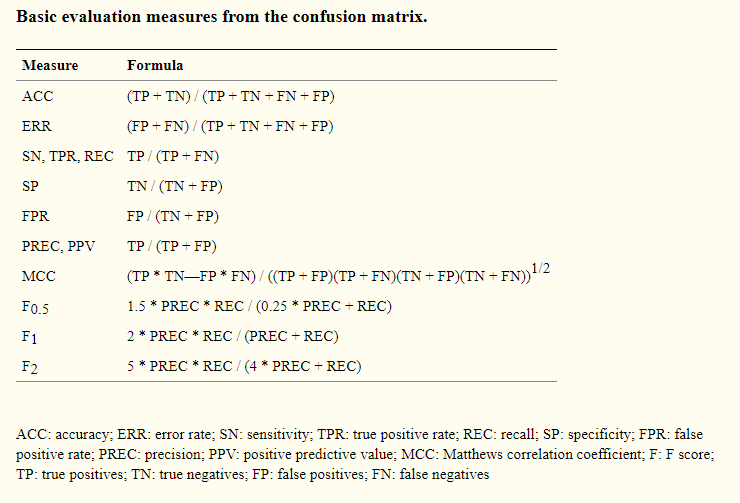

In [16]:
Image(filename='basic_measures_in_conf_matrix.png')

### AUC-ROC и AUC-PR


 **AUC-ROC (or ROC AUC) - the area (Area Under Curve) under the error curve (Receiver Operating Characteristic curve)**. This curve is a line from (0,0) to (1,1) in the coordinates of True Positive Rate (TPR) and False Positive Rate (FPR):

In [17]:
display(Math(r'\large TPR = \frac{TP}{TP + FN}')), display(Math(r'\large FPR = \frac{FP}{FP + TN}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(None, None)

 We already know **TPR, this is recall**, and **FPR** shows which fraction of the negative class objects the algorithm predicted incorrectly. In the ideal case, when the classifier does not make mistakes (FPR = 0, TPR = 1) we get the area under the curve equal to unity; otherwise, when the classifier accidentally gives class probabilities, AUC-ROC will tend to 0.5, since the classifier will produce the same number of TP and FP.

#### Для визуализации будем использовать функцию:

In [186]:
def show_auc(clf, X_train, y_train, X_test, y_test, plot_name, only_predict=False): 
    
    '''get into:
    
    1. clf - имя алгоритма
    2. X_train - тренировочные признаки/данные
    3. y_train - верные ответы для тренировочной выборки
    4. X_test - тестовые признаки/данные
    5. y_test - верные ответы для тестовой выборки
    6. plot_name - название для графика и имя сохраняемой картинки
    -----------------------------------------
    7. switch for models with one-dimensional prediction `only_predict=True`.
    
    return roc auc plot, y_pred_train, y_pred_test'''    

    # compute predict_proba
    if only_predict:
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
    else:
        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]
    
    
    fpr0, tpr0, ths0 = roc_curve(y_train, y_pred_train) # compute fpr, tpr, thresholds and roc_auc for train
    roc_auc0 = auc(fpr0, tpr0)    
    
    fpr, tpr, ths = roc_curve(y_test, y_pred_test) # compute fpr, tpr, thresholds for test
    roc_auc = auc(fpr, tpr) # compute area under the curve
    
    plt.figure()
    plt.plot(fpr0, tpr0, label='Train ROC curve (area = %0.4f)' % (roc_auc0), color='b')
    plt.plot(fpr, tpr, label='Test ROC curve (area = %0.4f)' % (roc_auc0), color='g')
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_name)
    plt.legend(loc="best")
    
    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, ths, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([ths[-1],ths[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])
    
     # print text
    print('Train ROC AUC: {0:.4f}'.format(roc_auc0))
    print('Test ROC AUC: {0:.4f}'.format(roc_auc))

    
    plt.savefig(f'{plot_name}.tiff', transparent=False, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    return y_pred_train, y_pred_test

**Also let's show the text report showing the main classification metrics for LogRegression.**

**Precision score of 1.0 for the class** means that every item labeled as belonging to class C does indeed belong to class (but says nothing about the number of items from class C that were not labeled correctly) whereas **a recall of 1.0** means that every item from class C was labeled as belonging to class C (but says nothing about how many items from other classes were incorrectly also labeled as belonging to class C).

We see  precision, recall and F1-score for each class. In this case, model didn't classify females. Here *recall value for male* means that every male from sample was labeled as belonging to male class (but says nothing about how many items from other class were incorrectly also labeled as belonging to class male).

**The report includes macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). Micro average (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise.**

#### Для вызова отчета используем функцию:

In [185]:
def clf_report(y_pred_test_round, y_test, target_names=target_names): 
    
    print(classification_report(y_test, y_pred_test_round))
    
    print('\nAccuracy: ', accuracy_score(y_test, y_pred_test_round))

# Basic models <a class="anchor" id="basic_models"></a>

## Import libraries and split dataset on train and test (25/75).

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [171]:
# выбираю часть данных количество представителей классов

X_cat = X_cat.iloc[30000:90000, :]
X_unspec = X_unspec.iloc[30000:90000, :]
X_std = X_std.iloc[30000:90000, :]
y = W_df.iloc[30000:90000,-1]

# оцениваю баланс классов

y.value_counts()

1    37565
0    22435
Name: male, dtype: int64

Чтобы сохранить баланс представителей класса в выборке, можно передать в `train_test_split` аргумент `stratify`.

In [172]:
X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.25, stratify=y)
X_unspec_train, X_unspec_test, y_train, y_test = train_test_split(X_unspec, y, test_size=0.25, stratify=y)
X_std_train, X_std_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, stratify=y)

#### Normilize `X_std` features.

In [173]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


scaler.fit(X_std_train.values)

X_std_train = scaler.transform(X_std_train)
X_std_test = scaler.transform(X_std_test)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


## Get seed

In [174]:
seed = 40

# Logistic regression <a class="anchor" id="Log"></a>
[back to contents](#contents)

**The logistic model** (or logit model) is used to model the probability of a certain class. This can be extended to model several classes of events. Each object being detected in the image would be assigned a probability between 0 and 1 and the sum adding to one.

**Logistic regression is a linear classifier, so you’ll use a linear function 𝑓(𝐱) = 𝑏₀ + 𝑏₁𝑥₁ + ⋯ + 𝑏ᵣ𝑥ᵣ, also called the logit. The variables 𝑏₀, 𝑏₁, …, 𝑏ᵣ are the estimators of the regression coefficients, which are also called the predicted weights or just coefficients.**

The logistic regression function 𝑝(𝐱) is the **sigmoid function of 𝑓(𝐱): 𝑝(𝐱) = 1 / (1 + exp(−𝑓(𝐱)).** As such, it’s often close to either 0 or 1. The function 𝑝(𝐱) is often interpreted as the predicted probability that the output for a given 𝐱 is equal to 1. Therefore, 1 − 𝑝(𝑥) is the probability that the output is 0.

Logistic regression determines the best predicted weights 𝑏₀, 𝑏₁, …, 𝑏ᵣ such that the function 𝑝(𝐱) is as close as possible to all actual responses 𝑦ᵢ, 𝑖 = 1, …, 𝑛, where 𝑛 is the number of observations. The process of calculating the best weights using available observations is called model training or fitting.

In [175]:
from sklearn.linear_model import LogisticRegression

In [176]:
clf_LR = LogisticRegression(random_state=seed)
clf_LR.fit(X_std_train, y_train)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=40, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Parameters and LogLoss function



**The logistic function of losses**, it underlies the logistic regression. Minimization of the logistic function of losses is a task that logistic regression solves, taking as a basis the principle of maximum likelihood.

Logloss minimization can be thought of as the task of maximizing accuracy by a fine for incorrect predictions. However, it should be noted that logloss extremely fines for the confidence of the classifier in the wrong answer.



To fine-tune the model for error, regularization is used - this is a way to reduce the complexity of the model in order to prevent retraining or fix an incorrectly posed problem. This is usually achieved by adding some a priori information to the problem statement.

* **penalty**: {'l1', default ='l2', 'elasticnet', 'none'}


* **C**: default = 1.0, should be positive float.

Like in **SVM**, smaller values specify stronger regularization.

In [27]:
HTML('<img src="https://nagornyy.me/img/content/svm_nonlin.png">')

### Let's calculate which features are most important for the model.
#### As we see, model sorted values from positives to negatives. For example, we can say that 'years_practicing' & 'specialty' are two parameters which has different 'weight' for the model, but we cannot say one parameter is more significant than another, they are equally important, just in a different way.

In [178]:
features = list(X_std.columns)

In [179]:
#create dictionary
LR_coefs = dict(zip(features, clf_LR.coef_[0]))
LR_coefs = sorted(LR_coefs.items(), key=lambda x: x[1], reverse=True)
LR_coefs

[('generic_rx_count', 0.6264003478362917),
 ('years_practicing', 0.5362326965655326),
 ('Surgery', 0.45613764417264574),
 ('Cardiology', 0.4307928325297432),
 ('Gastroenterology', 0.3293152755677759),
 ('brand_name_rx_count', 0.2293989565176628),
 ('practice', 0.2182980516236383),
 ('Nephrology', 0.20967455968888096),
 ('Pulmonology', 0.2007572689239158),
 ('urology', 0.19514624723096047),
 ('sport_medicine', 0.1813489345800973),
 ('Oncology', 0.18062485454536203),
 ('Radiology', 0.1723843447907293),
 ('paint_medicine', 0.15886605131416634),
 ('Psychiatry', 0.10084701447401473),
 ('Infectious', 0.07755034260758566),
 ('Geriatric', 0.07721718877622287),
 ('dentistry', 0.06469916545570613),
 ('West', 0.0601870475271022),
 ('Endocrinology', 0.043067263452794366),
 ('Rheumatology', 0.04197773659824819),
 ('immunology', 0.03827646902538449),
 ('South', 0.0180142181320972),
 ('urban', 0.008031826434264436),
 ('Midwest', -0.010589865665069092),
 ('pediatry', -0.06013267605363498),
 ('Northeas

Визуализируем классификацию на плоскости, взяв 3 наиболее выжных признака:

* `generic_rx_count`
* `years_practicing`
* `drugs_variety`

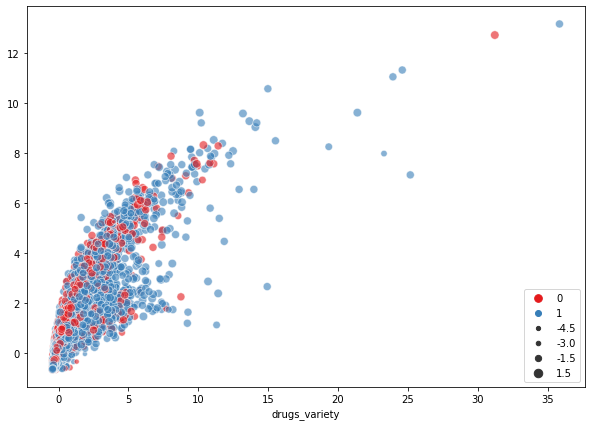

In [150]:
# транспонируем признаки из X_std_train
pltting_LR_train_result = X_std_train.T

# рисуем
plt.figure(figsize=(10,7))
ax = sns.scatterplot(x=pltting_LR_train_result[1],
                     y=pltting_LR_train_result[4],
                     size=pltting_LR_train_result[2],
                     hue=y_train.values,
                     palette='Set1', alpha=.6)

plt.legend(loc='lower right')
plt.xlabel('generic_rx_count')
plt.xlabel('drugs_variety')
plt.savefig('Train_classification_result.tiff', transparent=False, dpi=300, bbox_inches="tight")

### Estimate the model quality.

**Let's build the ROC curve, a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.**

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall. The false-positive rate is also known as probability of false alarm and can be calculated as (1 − specificity).

In this example we get probability of 1 (male) for test and train sets. 

**We can see, that classifier worked almost the same for train and test sets.**

Train ROC AUC: 0.7399
Test ROC AUC: 0.7475


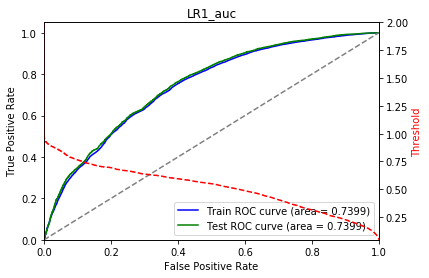

In [166]:
y_LR_pred_train, y_LR_pred_test = show_auc(clf_LR, X_std_train, y_train, X_std_test, y_test, 'LR1_auc')

**From the confusion matrix we can see that the correct predictions (classification of doctors) was 0 for female and 3646 correct predictions for male doctors.**

In [85]:
plot_confusion_matrix?

Результат выполнения функции `plot_confusion_matrix` присваетвается 2-м переменным:

* 1. таблица с показателями из CM
* 2. `y_pred_test_round` - набор округленных показателей для данной модели, чтобы позже посчитать `accuracy`

Confusion matrix, without normalization


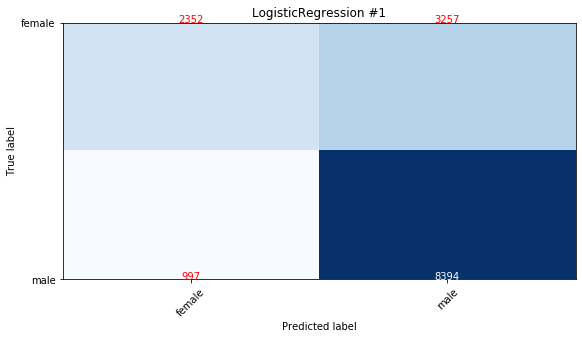

In [167]:
cm_df, y_LR_pred_test_round = plot_confusion_matrix(clf_LR, X_std_test, y_test, title='LogisticRegression #1')

Показатели складываются в переменную `cm_df`:

In [87]:
cm_df

,model,tn,fp,fn,tp
0,LogisticRegression #1,2321,3288,1068,8323


In [171]:
clf_report(y_LR_pred_test_round, y_test)

              precision    recall  f1-score   support

           0       0.70      0.42      0.53      5609
           1       0.72      0.89      0.80      9391

   micro avg       0.72      0.72      0.72     15000
   macro avg       0.71      0.66      0.66     15000
weighted avg       0.71      0.72      0.70     15000


Accuracy:  0.7164


#### Оптимизируем параметры вручную и с помощью кросс-валидации и `GridSearchCV`:

In [154]:
from sklearn.model_selection import GridSearchCV, cross_val_score

#### удаляю малозначимые признаки - это строки с 15 по 27(включительно)

In [155]:
len(LR_coefs[15:27]), X_std_train.shape

(12, (45000, 30))

In [156]:
# удаляю малозначимые признаки - это строки с 15 по 27(включительно)
X2_std_train= np.delete(X_std_train, np.s_[15:27], axis=1)  
X2_std_train.shape

(45000, 18)

In [157]:
clf_LR2 = LogisticRegression(random_state=seed)
LR2_params = {'C': range(1,51,5)}


LR2_grid = GridSearchCV(clf_LR2, LR2_params, cv=10, n_jobs=-1, verbose=True)

In [158]:
LR2_grid.fit(X_std_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.0s finished
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=40, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': range(1, 51, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=True)

In [159]:
LR2_grid.best_params_, LR2_grid.best_score_

({'C': 1}, 0.7109111111111112)

#### Результат изменился...

## LinearSVC <a class="anchor" id="LinearSVC"></a>
[back to contents](#contents)

**An SVM model** is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible.
Linear SVM is the newest extremely fast machine learning (data mining) algorithm for solving multiclass classification problems from ultra large data sets that implements an original proprietary version of a cutting plane algorithm for designing a linear **support vector machine.**
It has many advantages, such as:

•Efficiency in dealing with extra large data sets (say, several millions training data pairs)

•Solution of multiclass classification problems with any number of classes

•Working with high dimensional data (thousands of features, attributes) in both sparse and dense format

•No need for expensive computing resources (personal computer is a standard platform)

In [100]:
from sklearn.svm import SVC

In [110]:
clf_svc = SVC(random_state=seed)

clf_svc.fit(X_std_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=40,
  shrinking=True, tol=0.001, verbose=False)

Train ROC AUC: 0.6699
Test ROC AUC: 0.6766


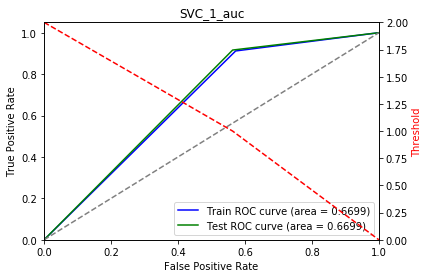

In [172]:
y_svm_pred_train, y_svm_pred_test = show_auc(clf_svc, X_std_train, y_train, X_std_test, y_test,
                                             'SVC_1_auc',only_predict=True)

Confusion matrix, without normalization


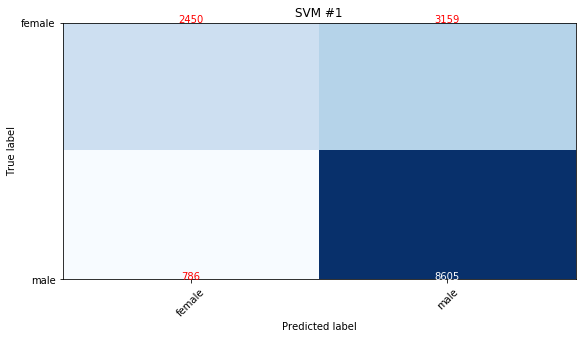

In [173]:
cm_svm, y_svm_pred_test_round = plot_confusion_matrix(clf_svc, X_std_test, y_test, title='SVM #1',only_predict=True)

In [174]:
cm_svm

,model,tn,fp,fn,tp
0,SVM #1,2450,3159,786,8605


### Добавляем рещультаты оценки алгоритма к таблице `cm_df`, в которой накапливаем все данные:

In [175]:
cm_df = cm_df.append(cm_svm, ignore_index=True)
cm_df

,model,tn,fp,fn,tp
0,LogisticRegression #1,2352,3257,997,8394
1,SVM #1,2450,3159,786,8605


In [176]:
clf_report(y_svm_pred_test_round, y_test)

              precision    recall  f1-score   support

           0       0.76      0.44      0.55      5609
           1       0.73      0.92      0.81      9391

   micro avg       0.74      0.74      0.74     15000
   macro avg       0.74      0.68      0.68     15000
weighted avg       0.74      0.74      0.72     15000


Accuracy:  0.737


#### Как видим, SVM чуть лучше справился с классификацией.

# kNN (K-Nearest Neighbors)<a class="anchor" id="kNN"></a>

[back to contents](#contents)

 **Classifier implementing the k-nearest neighbors vote.**
 
 The method is considered fast in comparison, for example, with compositions of algorithms, but in real problems, as a rule, the number of neighbors used for classification will be large (100-150), and in this case the algorithm will not work as fast as the decision tree.
 
 If there are a lot of features in the data set, then it is difficult to find the appropriate weights and determine which features are not important for classification / regression.
 
 Dependence on the chosen metric of distance between examples. The default choice of Euclidean distance is most often not justified by anything. You can find a good solution by enumerating the parameters, but for a large data set, this is time-consuming.
 
 There is no theoretical basis for choosing a certain number of neighbors - just busting (however, most often this is true for all hyperparameters of all models). In the case of a small number of neighbors, the method is sensitive to outliers, that is, it tends to retrain;

In [179]:
from sklearn.neighbors import KNeighborsClassifier

In [180]:
clf_knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

Now we build the **ROC curve**, a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

The **ROC curve** is created by plotting the **true positive rate (TPR) against the false positive rate (FPR)** at various threshold settings. The true-positive rate is also known as **sensitivity, recall**. The false-positive rate is also known as probability of false alarm and can be calculated as **(1 − specificity)**.

**In this example we get probability of 1 (male) for test and train sets. We can see, that classifier worked better on train set than on test, as ROC AUC for train set is bigger (0.8094).** 

Train:
ROC AUC: 0.8094
Test:
ROC AUC: 0.5501


0.5501479495726138

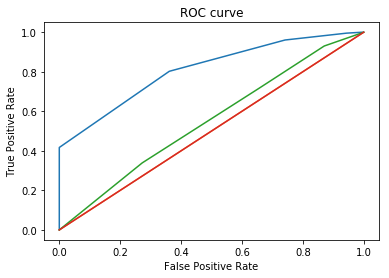

In [181]:
y_knn_pred_test = clf_knn.predict_proba(X_test)[:, 1]
y_knn_pred_train = clf_knn.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_knn_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_knn_pred_test, 'test')

**Let's show the text report showing the main classification metrics for k-NN classifier.**

We see  precision, recall and F1-score for each class. In this case, male metrics are better than for female. K-NN classifier shows better result than previous. 

**The report includes macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). Micro average (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise.**

In [182]:
y_knn_pred_test_round = np.around(y_knn_pred_test)
print(classification_report(y_test, y_knn_pred_test_round, target_names=target_names))

              precision    recall  f1-score   support

      female       0.32      0.13      0.18       903
        male       0.81      0.93      0.87      3646

   micro avg       0.77      0.77      0.77      4549
   macro avg       0.56      0.53      0.53      4549
weighted avg       0.71      0.77      0.73      4549



**From the confusion matrix we can see that the correct predictions (classification of doctors) was 117 for female and 3392 correct predictions for male doctors.**

Confusion matrix, without normalization
[[ 117  786]
 [ 254 3392]]


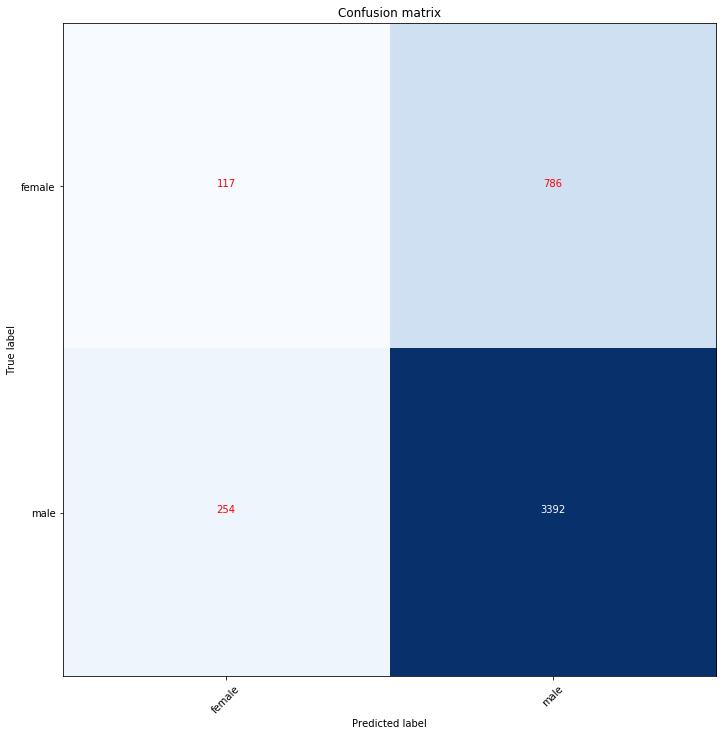

In [183]:
knn_cnf_matrix = confusion_matrix(y_test, y_knn_pred_test_round)

plt.figure(figsize=(10,12))


plot_confusion_matrix(knn_cnf_matrix, classes=['female', 'male'],
                      title='Confusion matrix')

plt.show()

In [184]:
accuracy_score(y_test, y_LR_pred_test_round)

0.801494834029457

In [185]:
X.shape, y.shape, y.value_counts()

((18196, 8), (18196,), 1    14424
 0     3772
 Name: male, dtype: int64)

**Using the following function, we find out how many neighbors for this model could reduce the classification error.**

**With values of K from 15 and above it is seen that the oscillations are not so large, but nevertheless they exist.**

In [224]:
error_rate = []
# Might take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

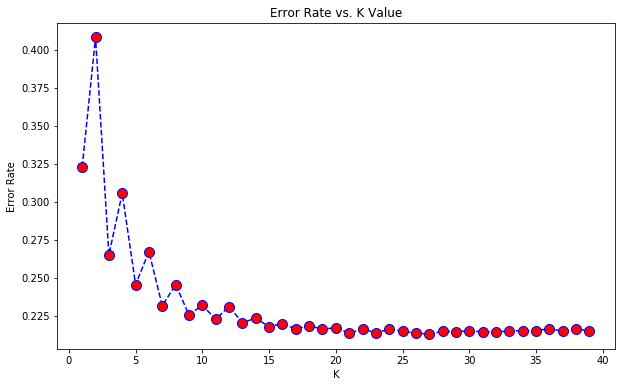

In [225]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [226]:
#Lets try take K = 22, and see how model will work in this case.
clf_knn = KNeighborsClassifier(n_neighbors=40, n_jobs=-1)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=40, p=2,
           weights='uniform')

**Test ROC AUC value improved slightly**

**Train ROC AUC value decreased**

Train:
ROC AUC: 0.6662
Test:
ROC AUC: 0.5870


0.586965896030223

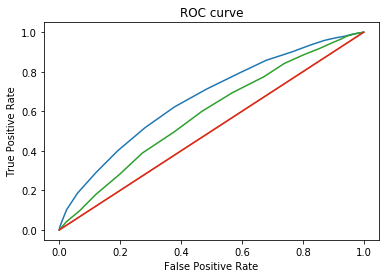

In [227]:
y_knn_pred_test = clf_knn.predict_proba(X_test)[:, 1]
y_knn_pred_train = clf_knn.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_knn_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_knn_pred_test, 'test')

**F1-score value got worse for female**

In [228]:
y_knn_pred_test_round = np.around(y_knn_pred_test)
print(classification_report(y_test, y_knn_pred_test_round, target_names=target_names))

              precision    recall  f1-score   support

      female       0.55      0.01      0.02       978
        male       0.79      1.00      0.88      3571

   micro avg       0.79      0.79      0.79      4549
   macro avg       0.67      0.50      0.45      4549
weighted avg       0.74      0.79      0.70      4549



**From the confusion matrix we can see that the correct predictions (classification of doctors) was 11 for female and 3562 correct predictions for male doctors.**

Confusion matrix, without normalization
[[  11  967]
 [   9 3562]]


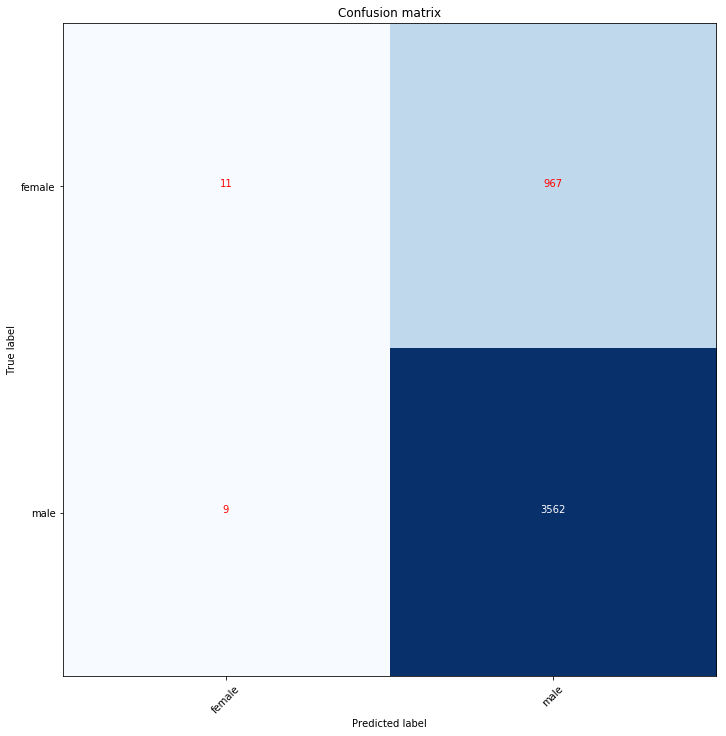

In [229]:
knn_cnf_matrix = confusion_matrix(y_test, y_knn_pred_test_round)

plt.figure(figsize=(10,12))


plot_confusion_matrix(knn_cnf_matrix, classes=['female', 'male'],
                      title='Confusion matrix')

plt.show()

### DecisionTreeClassifier<a class="anchor" id="dtc"></a>

[back to contents](#contents)

**Decision Trees (DTs)** are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [232]:
from sklearn.tree import DecisionTreeClassifier

clf_Tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4,
                              random_state=1)

clf_Tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

**No metrics for female.**

In [233]:
y_Tree_pred = clf_Tree.predict(X_test)
print(classification_report(y_test, y_Tree_pred, target_names=['female','male']))

              precision    recall  f1-score   support

      female       0.00      0.00      0.00       978
        male       0.78      1.00      0.88      3571

   micro avg       0.78      0.78      0.78      4549
   macro avg       0.39      0.50      0.44      4549
weighted avg       0.62      0.78      0.69      4549



**Here ROC AUC of train and test are close to each other.**

Train:
ROC AUC: 0.6981
Test:
ROC AUC: 0.6856


0.685586830746888

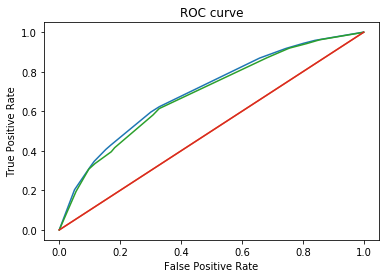

In [234]:
y_Tree_pred_test = clf_Tree.predict_proba(X_test)[:, 1]
y_Tree_pred_train = clf_Tree.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_Tree_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_Tree_pred_test, 'test')

In [235]:
y_Tree_pred_test_round = np.around(y_Tree_pred_test)
accuracy_score(y_test, y_Tree_pred_test_round)

0.7847878654649374

**We will take certain features to build decision tree.**

In [239]:
features = list(X.columns.to_list())
features

['specialty',
 'brand_name_rx_count',
 'generic_rx_count',
 'region',
 'years_practicing',
 'urban',
 'bn_rx_proportion',
 'drugs_variety']

In [240]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(clf_Tree,
                           filled=True, 
                           rounded=True,
                           class_names=['female','male'],
                           feature_names=features, 
                           out_file=None) 
graph = graph_from_dot_data(dot_data)
graph.write_png('tree1.png')

True

**Pictre shows that classifier builds tree with 4 nodes for class 'male' and different samples number. Each node has its own condition and if it is True or False, the model splits the tree into subtrees. Gini creates split points (entropy). 'Value' means how the sample is divided, in our case sample = [female_numbers, male_nmbers]. On the picture we can see, that classifier found two classes of female doctors.**

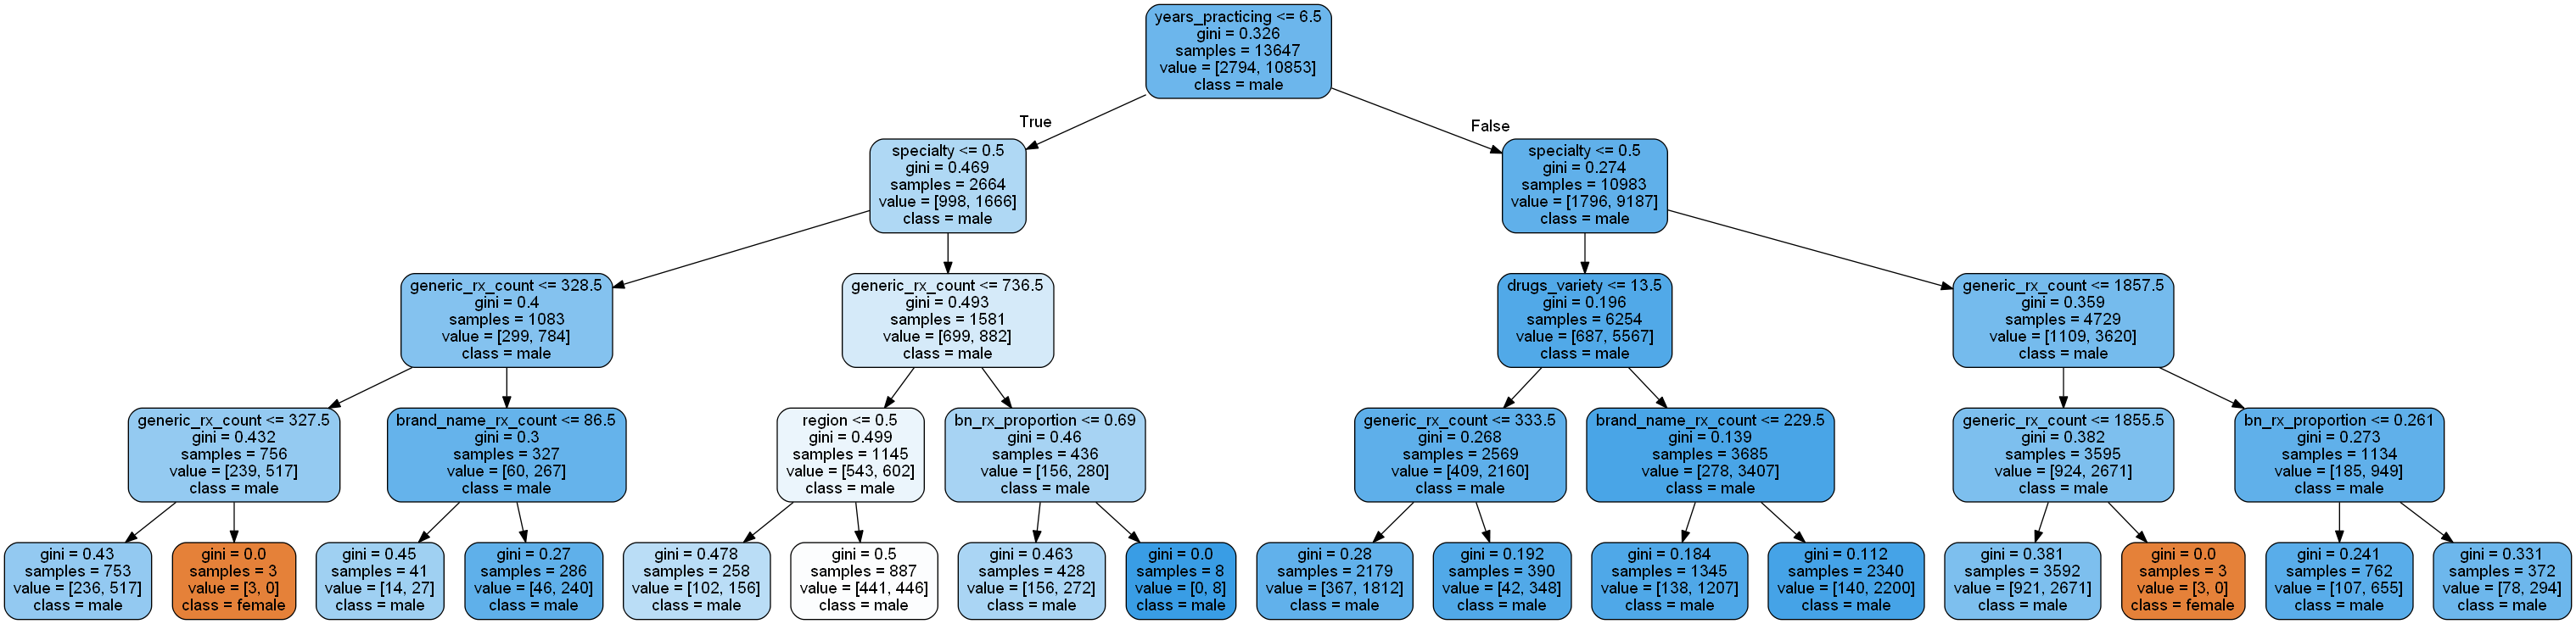

In [241]:
Image('tree1.png')

### Neural Network with [pytorch](https://pytorch.org/)

In [1]:
# после структурирования предыдущего материала, наичниать с этого метса
W_df = pd.read_csv('W_df.csv') 
W_df = W_df.set_index('npi')
W_df.head(2)

NameError: name 'pd' is not defined

In [128]:
X_w = W_df.iloc[:30000,1:-1]
y_w = W_df.iloc[:30000,-1]

In [129]:
X_w.shape

(30000, 31)

In [130]:
y_w.shape

(30000,)

In [131]:
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w, y_w, test_size=0.20, stratify=y_w)

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Переводим входящие данные в тип `numpy.ndarray` - тензор, тк с ним работает **pytorch**

In [133]:
X_w_train = X_w_train.to_numpy()
y_w_train = y_w_train.to_numpy()

Создаем алгоритм сети:

* `n_input` - количество фичей на входе
* `n_hidden` - количество персептронов в скрытом слое
* `n_output` - ответов на выходе

In [134]:
n_input = X.shape[1] # Number of inputs

# Layer size
n_hidden = 8 # Number of hidden nodes
n_output = 1 # Number of output nodes = for binary classifier

In [135]:
n_input

31

далее определяем функции передачи данных между слоями:

* [` nn.Linear()`](https://pytorch.org/docs/stable/nn.html#linear)
* [`nn.ELU()`](https://pytorch.org/docs/stable/nn.html#elu)
* [`nn.Sigmoid()`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [136]:
# Build network
clf_NN = nn.Sequential(
    nn.Linear(n_input, n_hidden),
    nn.ELU(),
    nn.Linear(n_hidden, n_output),
    nn.Sigmoid())
    
print(clf_NN)

Sequential(
  (0): Linear(in_features=31, out_features=8, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=8, out_features=1, bias=True)
  (3): Sigmoid()
)


Определим функцию потерь [`nn.BCELoss()`](https://pytorch.org/docs/stable/nn.html#bceloss), размер шага и алгоритм оптимизации — берем [Adam](https://arxiv.org/abs/1412.6980), можно пробовать другие варианты, уже реализованные в [pytorch](https://pytorch.org/docs/stable/optim.html#algorithms).

In [137]:
loss_func = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(clf_NN.parameters(), lr=learning_rate)

In [140]:
def run_clf_NN(X, y, clf_NN=clf_NN, epochs=500, loss_func=loss_func, lr=learning_rate, optimizer=optimizer):

    loss_list = []
    accuracy_list = []
    y_pred_list = []
    
    y_t = torch.FloatTensor(y).reshape(-1, 1)

    for e in range(epochs):
        X_t = torch.FloatTensor(X)
        y_hat = clf_NN(X_t)
        loss = loss_func(y_hat, y_t)

        # вычисляет значение ошибки/отклонения    
        loss.backward()
        # далее функци optimizer.step() обновляет веса опираясь на выявленную ошибку  
        optimizer.step()
        optimizer.zero_grad()
        y_hat_class = np.where(y_hat.detach().numpy()<0.5, 0, 1)
        accuracy = np.sum(y_w_train.reshape(-1,1)==y_hat_class) / len(y_w_train)
        
        # накапливаем данные    
        y_pred_list.append(y_hat_class)
        accuracy_list.append(accuracy)
        loss_list.append(loss.item())
        
        
    return y_pred_list, accuracy_list, loss_list

In [141]:
def plot_NN_study(plot_name, loss_list, accuracy_list):
    fig, ax = plt.subplots(2, 1, figsize=(12,8))
    ax[0].plot(loss_list)
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Accuracy through the epochs')

    ax[1].plot(accuracy_list)
    ax[1].set_ylabel('Classification Accuracy')
    ax[1].set_title('Accuracy through the epochs')
    plt.tight_layout()
    
    plt.savefig(f'{plot_name}.tiff', transparent=False, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

In [142]:
y_pred_list, accuracy_list, loss_list = run_clf_NN(X_w_train, y_w_train, epochs=800)

In [147]:
len(y_pred_list[-1])

24000

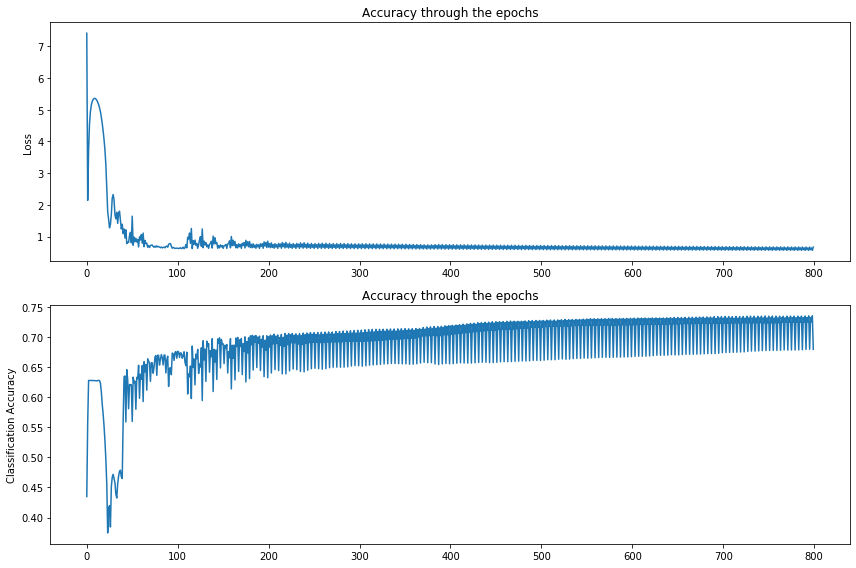

In [146]:
plot_NN_study('study_clf_NN', loss_list, accuracy_list)

In [149]:
accuracy_list[-2]

0.735375

## Ансамбли <a class="anchor" id="ensembles"></a>

[back to contents](#contents)

### Теорема Кондорсе «о жюри присяжных» (1784).
Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных.


$N$ — количество присяжных

$p$ — вероятность правильного решения присяжного

$μ$— вероятность правильного решения всего жюри

$m$ — минимальное большинство членов жюри, $m = \text{floor}(N/2) + 1$

$C^i_N$ - число сочетаний из $N$ по $i$

$$\large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i}$$

Если $p>0.5$, то $\mu>p$

Если $N \rightarrow \infty$, то $\mu \rightarrow 1$

### RandomForestClassifier<a class="anchor" id="rfc"></a>

[back to contents](#contents)


**A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).**

In [242]:
from sklearn.ensemble import RandomForestClassifier

Feature ranking:
1. generic_rx_count (0.263090)
2. bn_rx_proportion (0.204383)
3. brand_name_rx_count (0.197700)
4. drugs_variety (0.153522)
5. years_practicing (0.073755)
6. region (0.054090)
7. specialty (0.032443)
8. urban (0.021016)


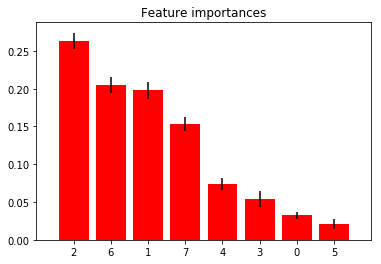

In [243]:
clf_RF = RandomForestClassifier(n_estimators=250,
                              random_state=10,
                              n_jobs=-1)

clf_RF.fit(X_train, y_train)
importances = clf_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [244]:
y_RF_pred = clf_RF.predict(X_test)
print(classification_report(y_test, y_RF_pred, target_names=['female','male']))

              precision    recall  f1-score   support

      female       0.37      0.12      0.19       978
        male       0.80      0.94      0.86      3571

   micro avg       0.77      0.77      0.77      4549
   macro avg       0.58      0.53      0.52      4549
weighted avg       0.71      0.77      0.72      4549



In [245]:
y_RF_pred_test_round = np.around(y_RF_pred)
accuracy_score(y_test, y_RF_pred_test_round)

0.7667619256979556

# Bagging

<a class="anchor" id="bagging"></a>

[back to contents](#contents)


Беггинг - общий подход к уменьшению дисперсии алгоритма машинного обучения. Беггинг происходит от фразы bootstrap aggregation. Bootstrap выборка - это просто выборка с повторением.

In [153]:
HTML('<img src="https://habrastorage.org/getpro/habr/post_images/198/14a/3f7/19814a3f7efaa3b7d1a3f8ab35889832.jpg">')

In [180]:
# после структурирования предыдущего материала, наичниать с этого метса
W_df = pd.read_csv('W_df.csv') 
W_df = W_df.set_index('npi')
X_w = W_df.iloc[:30000,1:-1]
y_w = W_df.iloc[:30000,-1]

In [181]:
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w, y_w, test_size=0.20, stratify=y_w)

In [182]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_LR, n_jobs=-1)
bag_clf.fit(X_w_train, y_w_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=40, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [184]:
y_pred_test = bag_clf.predict_proba(X_w_test)[:, 1]
y_pred_train = bag_clf.predict_proba(X_w_train)[:, 1]

In [ ]:
cm_bag, plot_confusion_matrix(bag_clf, X_w_test, y_w_test, title='_____')

In [193]:
y_LR_pred_train, y_LR_pred_test = show_auc(bag_clf, X_w_train, y_w_train, X_w_test, y_w_test, title='Bagging_AUC')

TypeError: show_auc() got an unexpected keyword argument 'title'

Train ROC AUC: 0.7450
Test ROC AUC: 0.7383


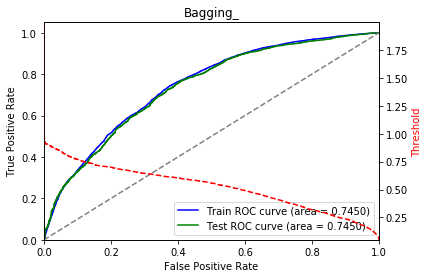

(array([0.71588949, 0.69714276, 0.54538185, ..., 0.75490625, 0.88718005,
        0.47032193]),
 array([0.75149909, 0.80234623, 0.75444013, ..., 0.62980017, 0.55761373,
        0.37817787]))

In [192]:
show_auc(bag_clf, X_w_train, y_w_train, X_w_test, y_w_test, 'Bagging_')

In [ ]:
def show_auc(clf, X_train, y_train, X_test, y_test, plot_name, only_predict=False): 
    


def clf_report(y_pred_test_round, y_test, target_names=target_names): 
    
    print(classification_report(y_test, y_pred_test_round))
    
    print('\nAccuracy: ', accuracy_score(y_test, y_pred_test_round))

## Stacked Ensembles

<a class="anchor" id="blending"></a>

[back to contents](#contents)


Главная идея - почему ансамблирование моделей делается таким простым способом, как усреднение? Что если доверить это делому другому алгоритму машинного обучения?

### Blending

Простейшая схема стекинга — блендинг (Blending): обучающую выборку делят на две части. На первой обучают базовые алгоритмы. Затем получают их ответы на второй части и на тестовой выборке. Понятно, что  ответ каждого алгоритма можно рассматривать как новый признак (т.н. «метапризнак»). На метапризнаках второй части обучения настраивают метаалгоритм. Затем запускают его на метапризнаках теста и получают ответ.


Основной недостаток - деление обучающей выборки. Никакой из алгоритмов не использует всех данных для обучения.

<img src="stacking.png" style="max-width: 680px; display: inline" />



## Stacking

<a class="anchor" id="stack"></a>

[back to contents](#contents)

Выборку разбиваем на фолды, затем последовательно перебираем фолды и обучаем базовые алгоритмы на всех фолдах, кроме одного, а на оставшемся получаем ответы базовых алгоритмов и трактуем их как значения соответствующих признаков на этом фолде. Для получения метапризнаков объектов тестовой выборки базовые алгоритмы обучают на всей обучающей выборке и берут их ответы на тестовой.

<img src="stacking-2b.png" style="max-width: 680px; display: inline" />

In [ ]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    
    # массивы для ответов базовых алгоритмов 
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        
        # ответы классификаторов на изначальной тестовой выборке, которые после идут для обучения мета-модели
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        
        # отложенная изначально выборка предсказываем ответы базовыми классификаторами ниже мы их усредним
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

In [ ]:
from sklearn.model_selection import StratifiedKFold

# разбиваем выборку на 10 частей
stack_cv = StratifiedKFold(n_splits=10, random_state=seed)

meta_train = []
meta_test = []
col_names = []

# записываем ответы алгоритмов
print('LR features...')
meta_tr, meta_te = get_meta_features(clf_LR, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_RF, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

In [ ]:
# собираем данные
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [ ]:
# запускаем мета алгоритм
clf_lr_meta = LogisticRegression(penalty='l2', C=1)
clf_lr_meta.fit(X_meta_train, y_train)

In [ ]:
y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]